In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [7]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

import pickle

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


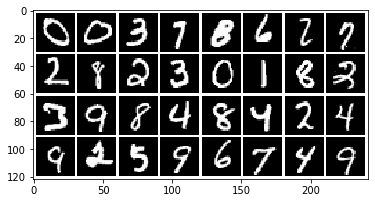

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
def calc_meas(x):
    m = A.shape[1]
    n = x.shape[-1] * x.shape[-2]
    assert(m <= n)
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, m)
    compressed = torch.abs(compressed)

    compr_pad = nn.functional.pad(compressed, (0, n - m), mode='constant', value=0).reshape(x.shape)
    
    return compressed, compr_pad

# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        _, meas_pad = calc_meas(data)
        net_input = torch.cat([z, meas_pad], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [6]:
# Define Gen and Disc loss
def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [7]:
m = 25 # 10, 25, 50, 100, 200, 300, 500, 784

import pickle

#A = (torch.randn(imsize[1] * imsize[2], m) / m).to(device)
#pickle.dump(A, open("../cache/A/A{}.p".format(m), "wb"))

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

print(A.shape)

torch.Size([784, 25])


In [8]:
### Create new models ###

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

Version 0.4


In [9]:
# Set training parameters

lmd = 1e3 # loss signal

g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)

In [10]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
_, sample_meas_pad = calc_meas(sample)

zm = torch.cat([torch.randn(*sample.shape).to(device), sample_meas_pad], dim=1)
gen_out = gen(zm)

xm = torch.cat([sample, sample_meas_pad], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_meas_pad], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 474.0521240234375
Discriminator initial loss: 0.8011314868927002


In [11]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        print("Starting epoch {}".format(e+1))
        
        with tqdm(total=len(loader_train.dataset)) as progress_bar:
            for t, x in enumerate(loader_train):
                
                # move x to device and reduce to magnitude information in fourier space
                x = x.to(device=device)
                _, meas_pad = calc_meas(x)

                # stack magnitudes to noise / generator input
                z = torch.randn(*x.shape).to(device)
                zm = torch.cat([z, meas_pad], dim=1)

                # calc gen output
                gen.train()
                gen_output = gen(zm)

                # calc disc output for real and generated image
                xm = torch.cat([x, meas_pad], dim=1)
                disc.train()
                disc_output_real = disc(xm)
                disc_output_generated = disc(torch.cat([gen_output, meas_pad], dim=1))

                # calculate generator loss and update generator
                g_loss = gen_loss(disc_output_generated, gen(zm), x, lmd)
                history_g.append(g_loss.item())
                g_opt.zero_grad()
                g_loss.backward(retain_graph=True)
                #torch.nn.utils.clip_grad_value_(gen.parameters(), 1e-1)
                g_opt.step()

                # calculate discriminator loss and update discriminator
                d_loss = disc_loss(disc_output_real, disc_output_generated)
                history_d.append(d_loss.item())
                d_opt.zero_grad()
                d_loss.backward()
                #torch.nn.utils.clip_grad_value_(disc.parameters(), 1e-1)
                d_opt.step()

                mse_loss = torch.mean((x - gen_output) ** 2)
                history_mse.append(mse_loss.detach().cpu().item())

                progress_bar.set_postfix(g_loss=np.mean(history_g[-100:]),
                                         d_loss=np.mean(history_d[-100:]),
                                         mse=np.mean(history_mse[-100:]))
                progress_bar.update(x.size(0))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
        test_images, test_outputs = test_generator(gen, device, dataloader['val'])
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("MSE validation:", mse_val)
        
        gen_weights = gen.state_dict().copy()
        disc_weights = disc.state_dict().copy()
        #torch.save(gen_weights, "../cache/FCGenerator2048MNIST_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #torch.save(disc_weights, "../cache/ConvDiscriminator64MNIST_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #if mse_val < 0.012:
        #    break
        
    return mse_val

  0%|          | 0/60000 [00:00<?, ?it/s]

Starting epoch 1


100%|██████████| 60000/60000 [00:36<00:00, 1625.48it/s, d_loss=0.00145, g_loss=128, mse=0.0853]


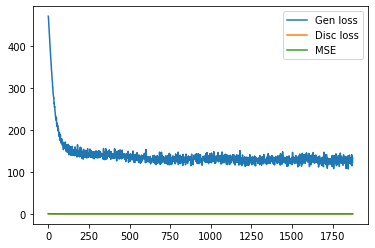

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


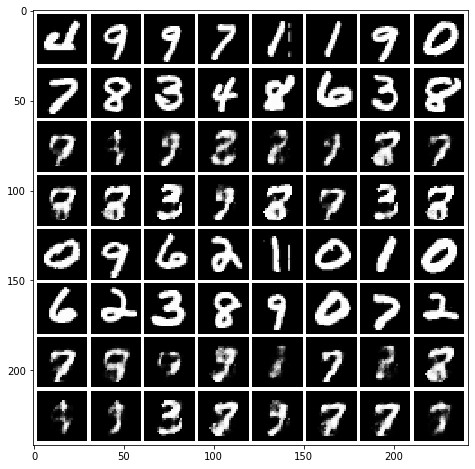

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.08778063
Starting epoch 2


100%|██████████| 60000/60000 [00:40<00:00, 1495.82it/s, d_loss=0.00242, g_loss=125, mse=0.0835]


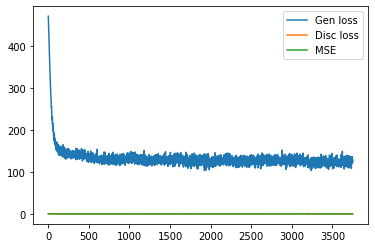

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


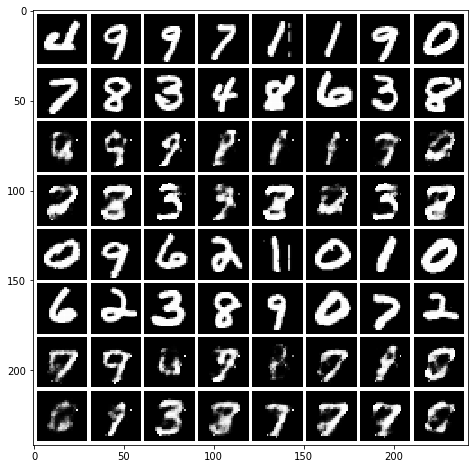

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.084816255
Starting epoch 3


100%|██████████| 60000/60000 [00:38<00:00, 1549.08it/s, d_loss=0.00543, g_loss=123, mse=0.0826]


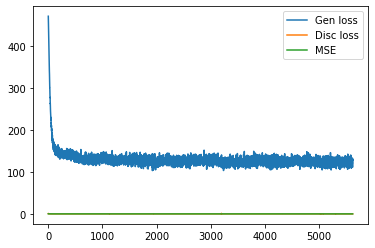

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


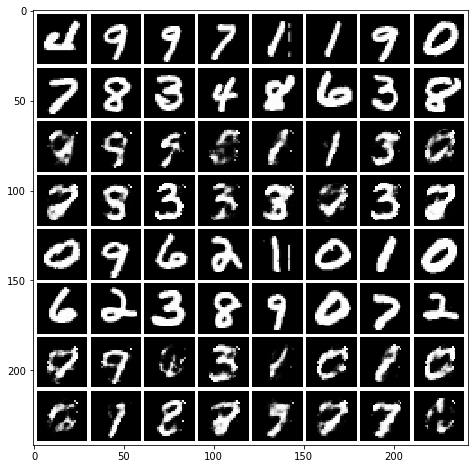

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.082615584
Starting epoch 4


100%|██████████| 60000/60000 [00:37<00:00, 1591.10it/s, d_loss=0.0105, g_loss=122, mse=0.0812] 


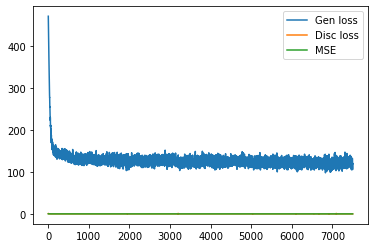

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


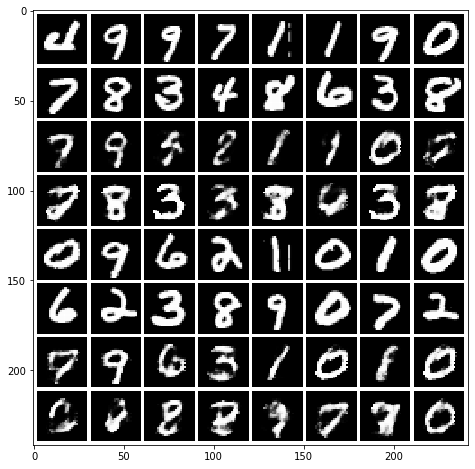

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07837724
Starting epoch 5


100%|██████████| 60000/60000 [00:34<00:00, 1735.96it/s, d_loss=0.0095, g_loss=121, mse=0.08]   


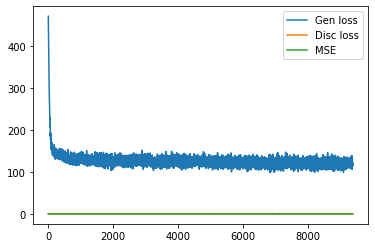

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


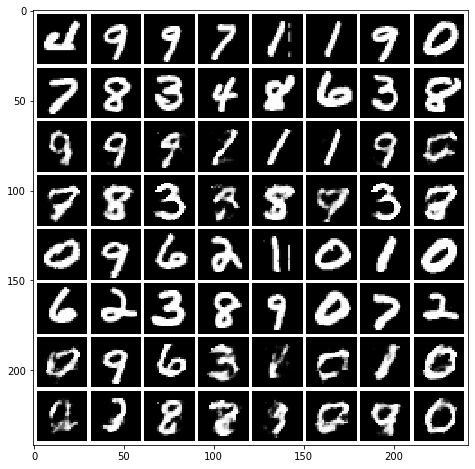

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.078296505
Starting epoch 6


100%|██████████| 60000/60000 [00:36<00:00, 1634.13it/s, d_loss=0.00919, g_loss=119, mse=0.0787]


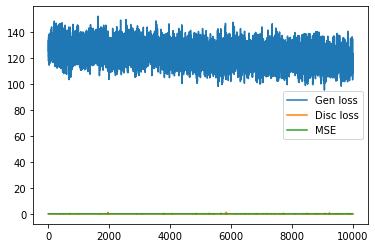

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


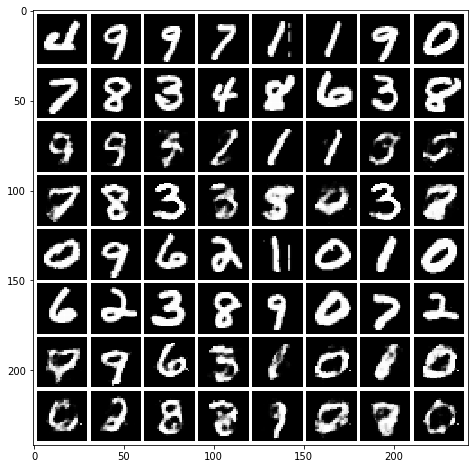

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07733806
Starting epoch 7


100%|██████████| 60000/60000 [00:35<00:00, 1699.74it/s, d_loss=0.0116, g_loss=119, mse=0.0798] 


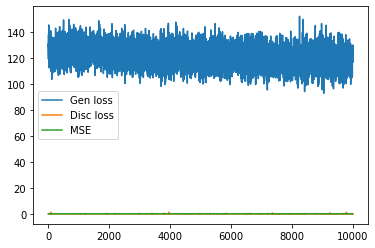

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


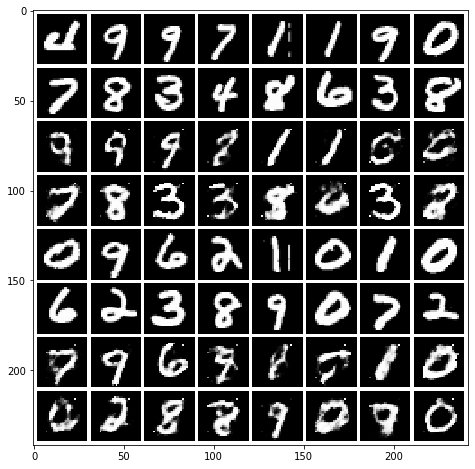

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07810311
Starting epoch 8


100%|██████████| 60000/60000 [00:35<00:00, 1677.09it/s, d_loss=0.0264, g_loss=119, mse=0.0795] 


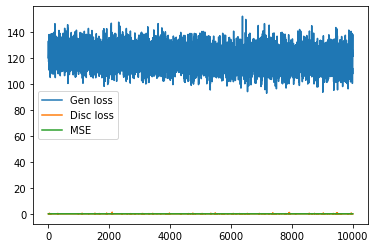

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


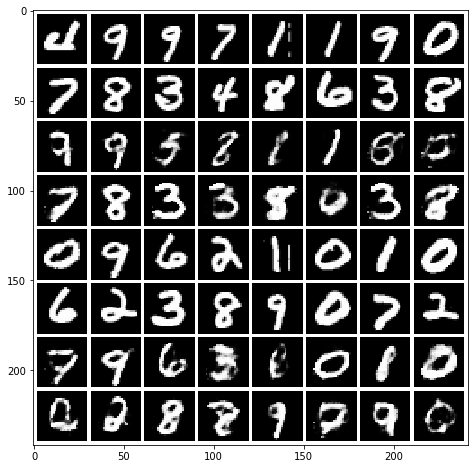

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07701579
Starting epoch 9


100%|██████████| 60000/60000 [00:35<00:00, 1697.06it/s, d_loss=0.0217, g_loss=116, mse=0.077]  


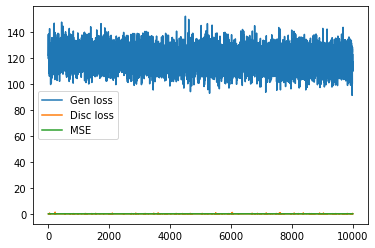

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


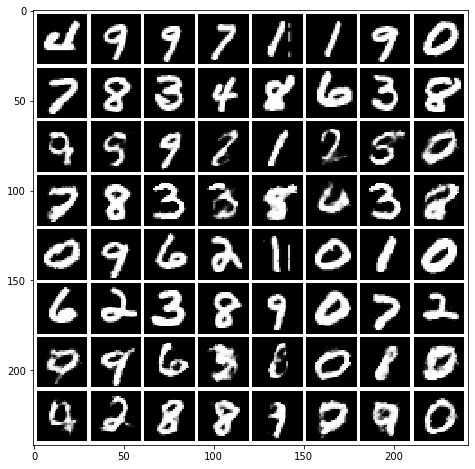

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07758621
Starting epoch 10


100%|██████████| 60000/60000 [00:35<00:00, 1682.61it/s, d_loss=0.015, g_loss=118, mse=0.0795]  


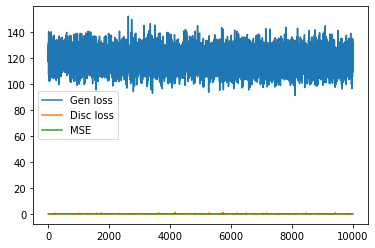

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


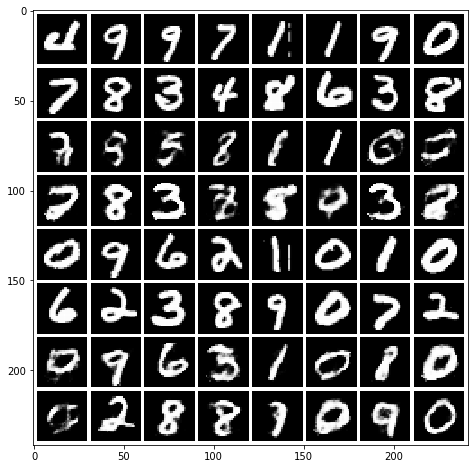

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0765013
Starting epoch 11


100%|██████████| 60000/60000 [00:35<00:00, 1703.58it/s, d_loss=0.00977, g_loss=119, mse=0.0806]


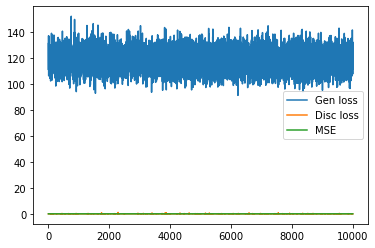

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


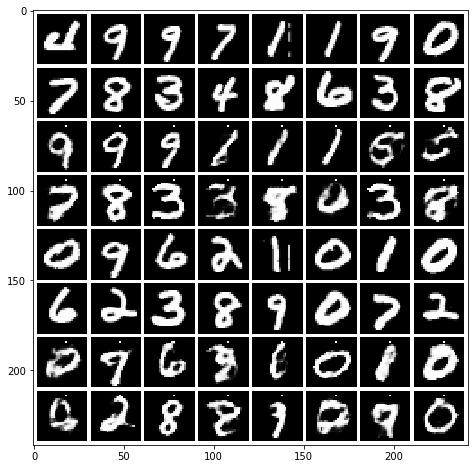

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07811169
Starting epoch 12


100%|██████████| 60000/60000 [00:36<00:00, 1694.03it/s, d_loss=0.0113, g_loss=117, mse=0.0791] 


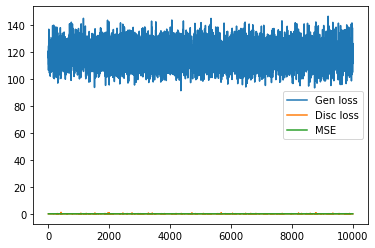

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


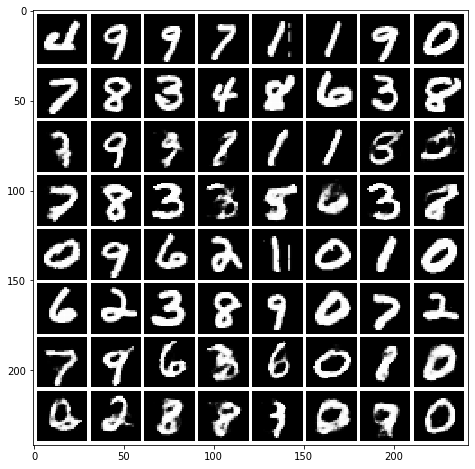

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07623426
Starting epoch 13


100%|██████████| 60000/60000 [00:35<00:00, 1682.24it/s, d_loss=0.0278, g_loss=116, mse=0.0785] 


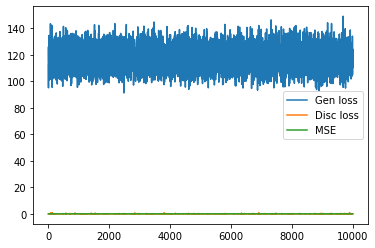

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


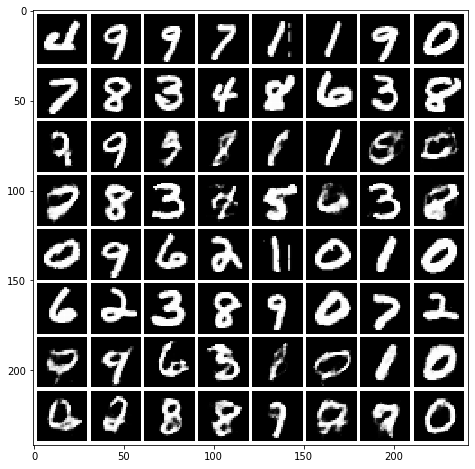

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07509677
Starting epoch 14


100%|██████████| 60000/60000 [00:35<00:00, 1585.29it/s, d_loss=0.0158, g_loss=117, mse=0.0786] 


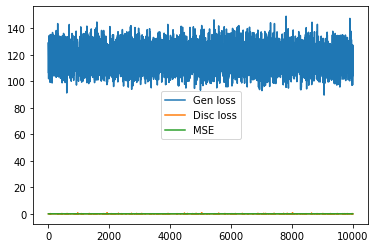

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


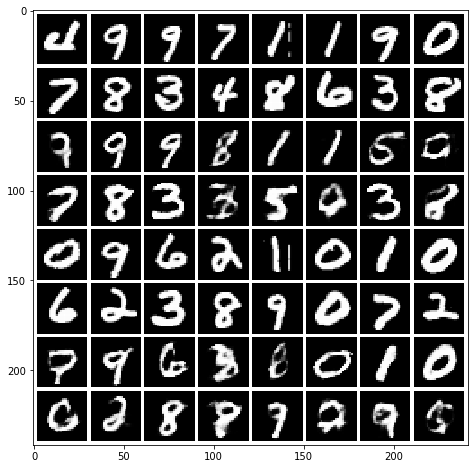

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0765308
Starting epoch 15


100%|██████████| 60000/60000 [00:35<00:00, 1674.13it/s, d_loss=0.00921, g_loss=117, mse=0.0791]


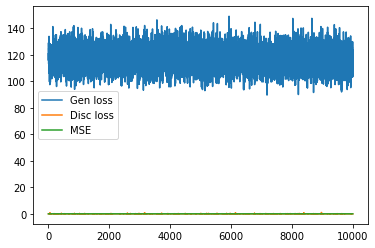

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


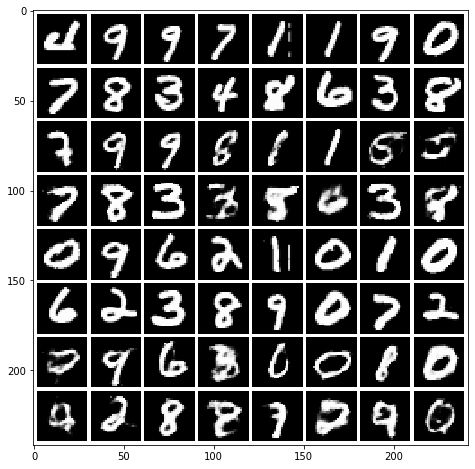

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07671228
Starting epoch 16


100%|██████████| 60000/60000 [00:35<00:00, 1673.21it/s, d_loss=0.00907, g_loss=117, mse=0.0788]


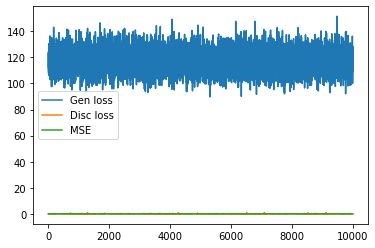

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


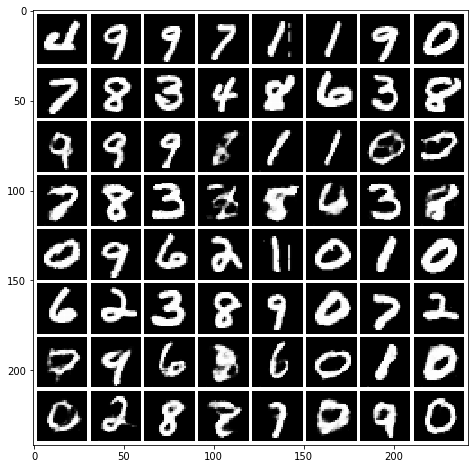

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077046245
Starting epoch 17


100%|██████████| 60000/60000 [00:36<00:00, 1655.36it/s, d_loss=0.00739, g_loss=119, mse=0.0806]


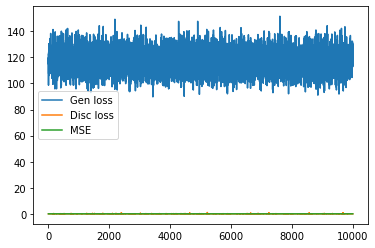

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


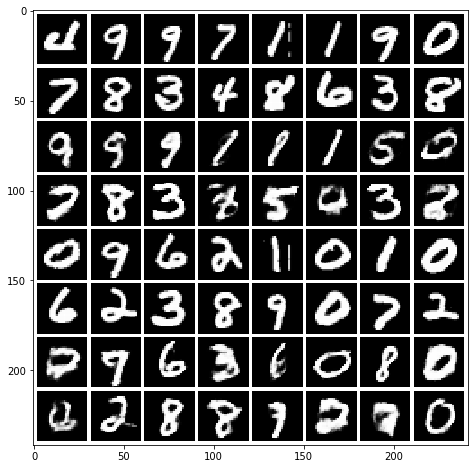

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07847849
Starting epoch 18


100%|██████████| 60000/60000 [00:35<00:00, 1698.88it/s, d_loss=0.0116, g_loss=117, mse=0.0793] 


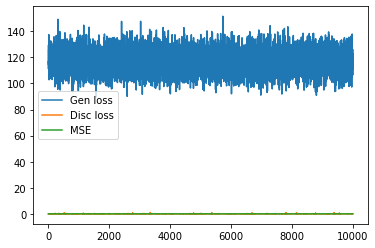

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


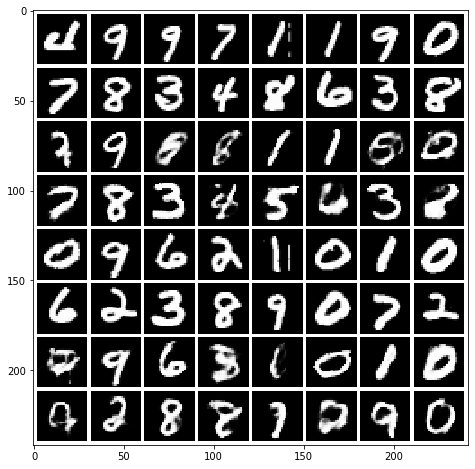

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07629192
Starting epoch 19


100%|██████████| 60000/60000 [00:35<00:00, 1678.69it/s, d_loss=0.0107, g_loss=117, mse=0.0789] 


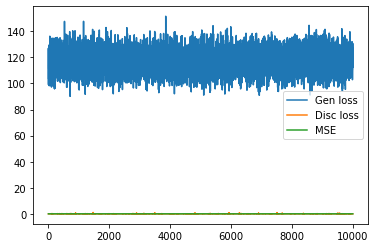

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


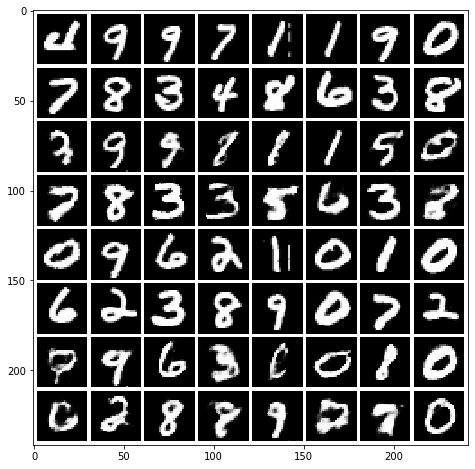

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077281475
Starting epoch 20


100%|██████████| 60000/60000 [00:35<00:00, 1667.51it/s, d_loss=0.00556, g_loss=116, mse=0.0787]


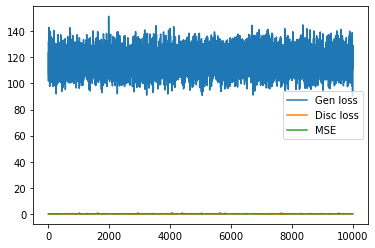

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


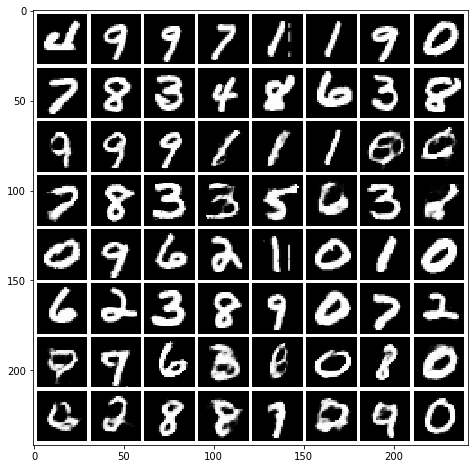

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07753073
Starting epoch 21


100%|██████████| 60000/60000 [00:35<00:00, 1685.39it/s, d_loss=0.014, g_loss=117, mse=0.0797]  


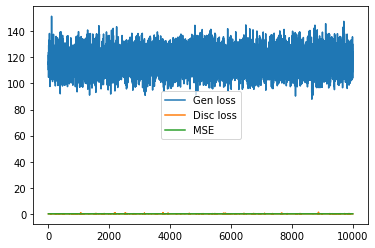

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


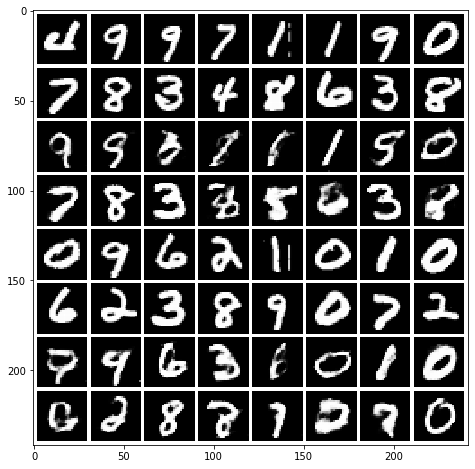

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07715564
Starting epoch 22


100%|██████████| 60000/60000 [00:35<00:00, 1676.02it/s, d_loss=0.013, g_loss=118, mse=0.0799]  


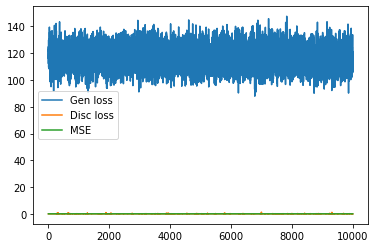

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


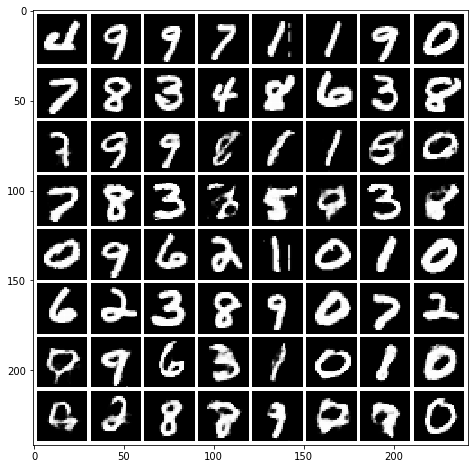

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07682955
Starting epoch 23


100%|██████████| 60000/60000 [00:35<00:00, 1670.24it/s, d_loss=0.00865, g_loss=117, mse=0.0801]


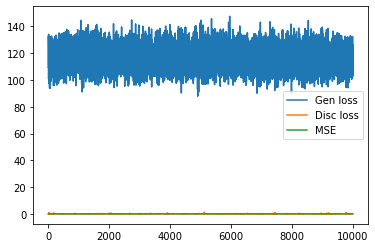

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


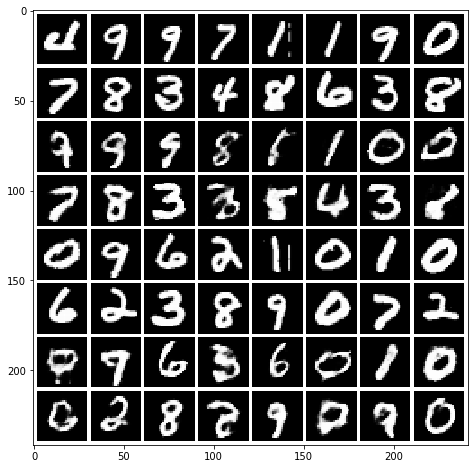

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07784845
Starting epoch 24


100%|██████████| 60000/60000 [00:38<00:00, 1562.66it/s, d_loss=0.0105, g_loss=117, mse=0.0794] 


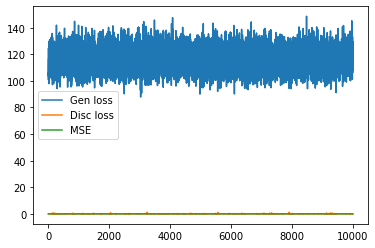

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


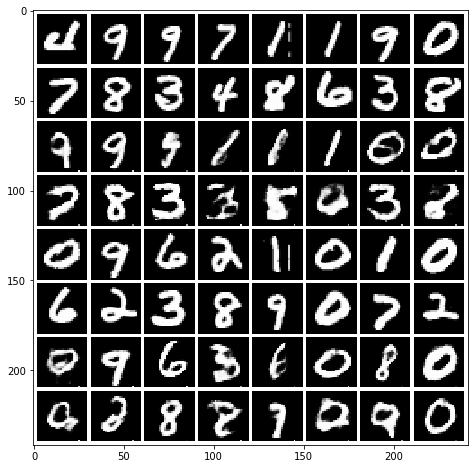

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07729138
Starting epoch 25


100%|██████████| 60000/60000 [00:36<00:00, 1645.58it/s, d_loss=0.0153, g_loss=115, mse=0.0782] 


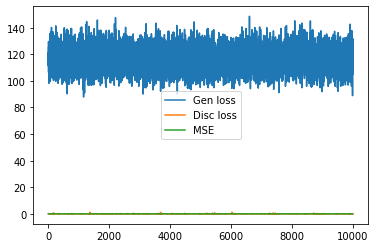

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


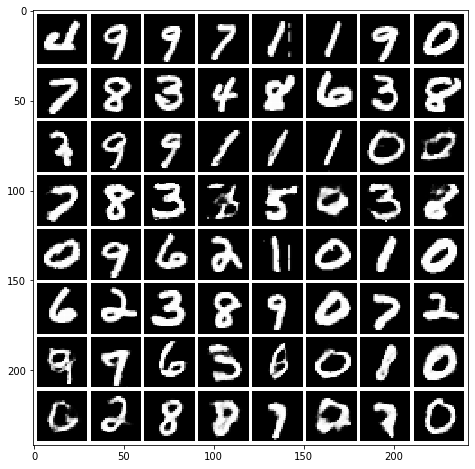

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077321
Starting epoch 26


100%|██████████| 60000/60000 [00:35<00:00, 1676.07it/s, d_loss=0.0107, g_loss=118, mse=0.0803] 


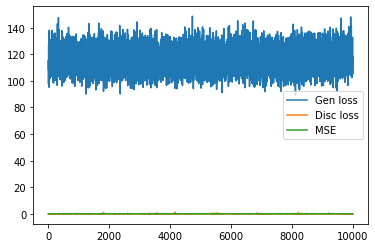

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


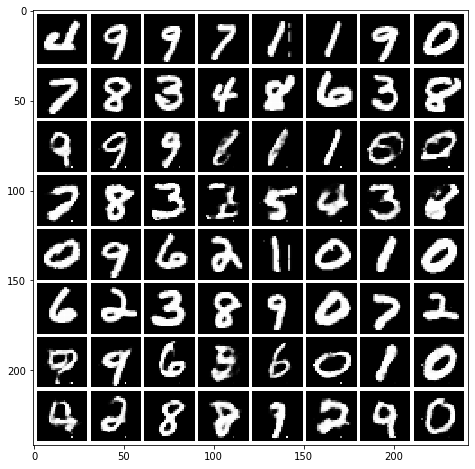

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07802039
Starting epoch 27


100%|██████████| 60000/60000 [00:36<00:00, 1650.96it/s, d_loss=0.00769, g_loss=117, mse=0.0788]


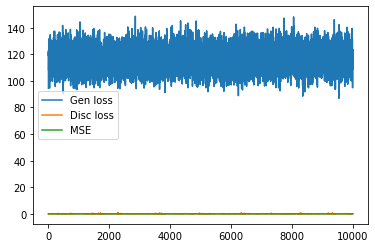

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


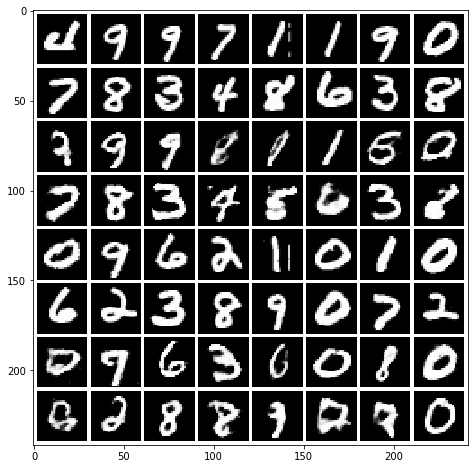

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.078549445
Starting epoch 28


100%|██████████| 60000/60000 [00:35<00:00, 1673.95it/s, d_loss=0.0121, g_loss=116, mse=0.0786] 


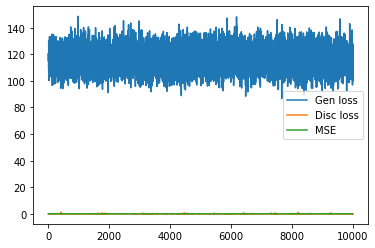

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


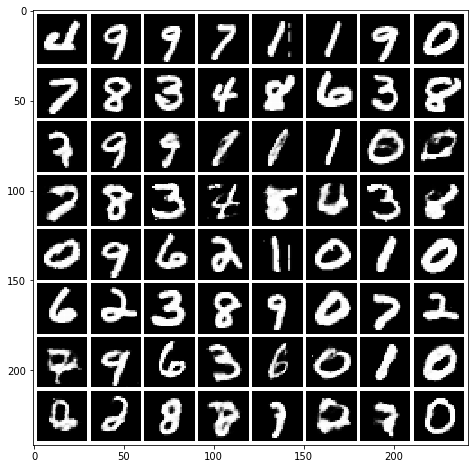

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07753098
Starting epoch 29


100%|██████████| 60000/60000 [00:35<00:00, 1698.40it/s, d_loss=0.0144, g_loss=116, mse=0.0788] 


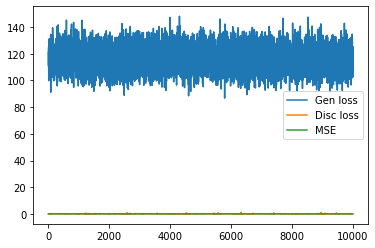

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


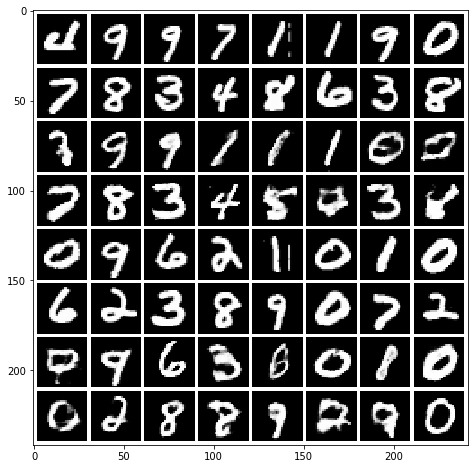

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0772904
Starting epoch 30


100%|██████████| 60000/60000 [00:36<00:00, 1653.25it/s, d_loss=0.00766, g_loss=118, mse=0.0802]


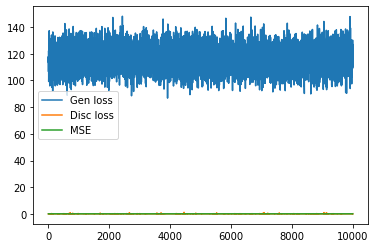

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


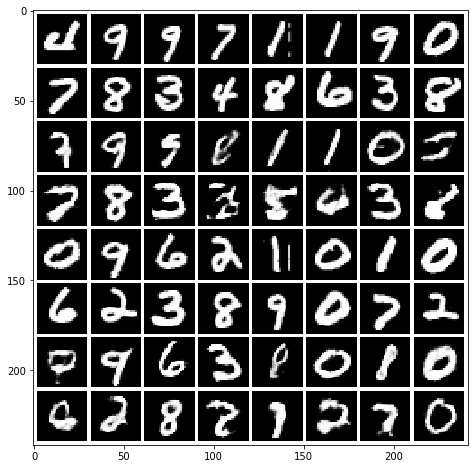

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0772136
Starting epoch 31


100%|██████████| 60000/60000 [00:37<00:00, 1604.90it/s, d_loss=0.00479, g_loss=119, mse=0.0803]


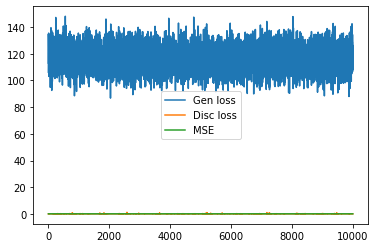

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


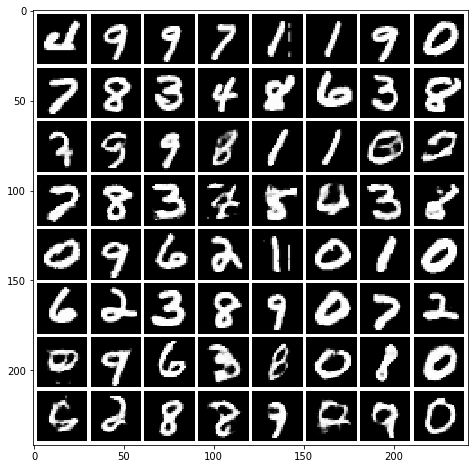

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07753806
Starting epoch 32


100%|██████████| 60000/60000 [00:39<00:00, 1526.13it/s, d_loss=0.00722, g_loss=116, mse=0.0777]


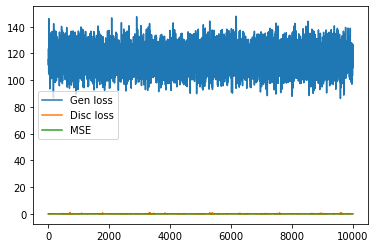

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


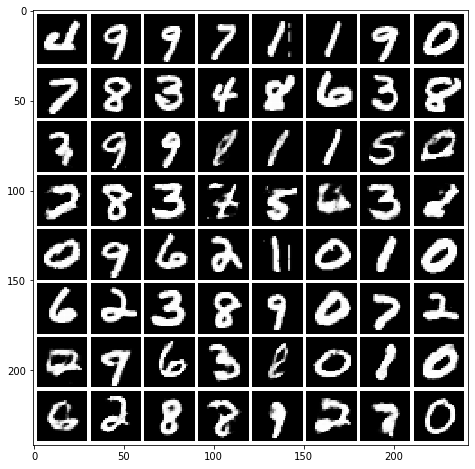

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07748883
Starting epoch 33


100%|██████████| 60000/60000 [00:39<00:00, 1512.21it/s, d_loss=0.00599, g_loss=117, mse=0.0791]


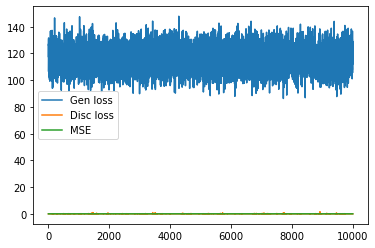

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


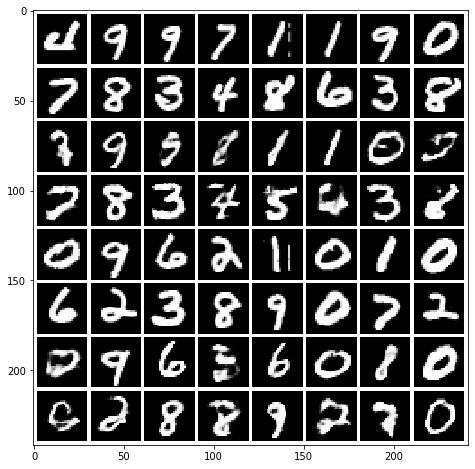

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077138685
Starting epoch 34


100%|██████████| 60000/60000 [00:39<00:00, 1525.71it/s, d_loss=0.00758, g_loss=118, mse=0.0793]


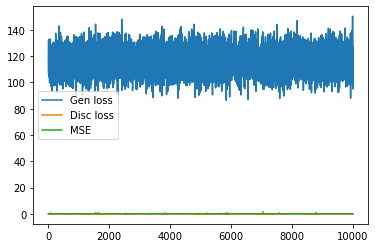

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


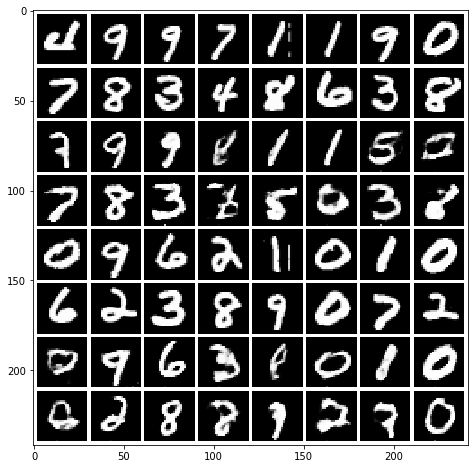

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07695732
Starting epoch 35


100%|██████████| 60000/60000 [00:38<00:00, 1577.34it/s, d_loss=0.006, g_loss=117, mse=0.0787]  


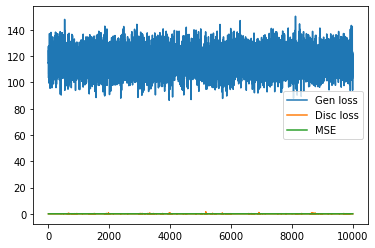

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


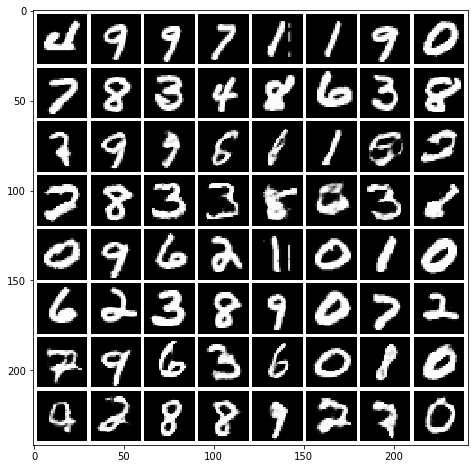

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07787125
Starting epoch 36


100%|██████████| 60000/60000 [00:39<00:00, 1504.50it/s, d_loss=0.012, g_loss=117, mse=0.0789]  


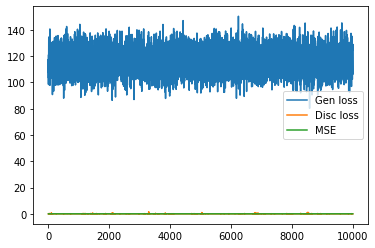

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


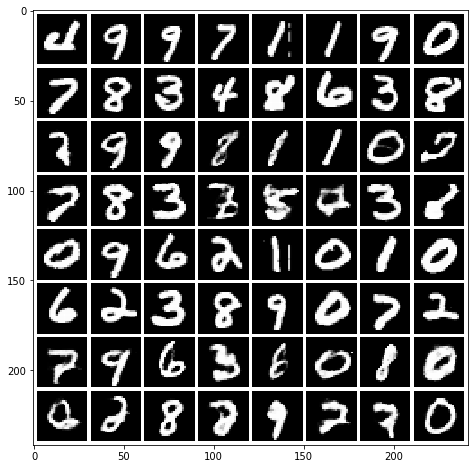

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07772865
Starting epoch 37


100%|██████████| 60000/60000 [00:40<00:00, 1466.61it/s, d_loss=0.00798, g_loss=117, mse=0.079] 


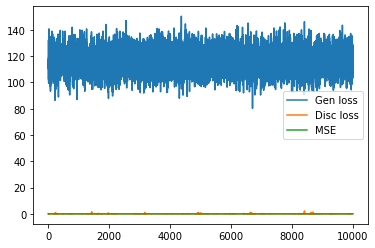

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


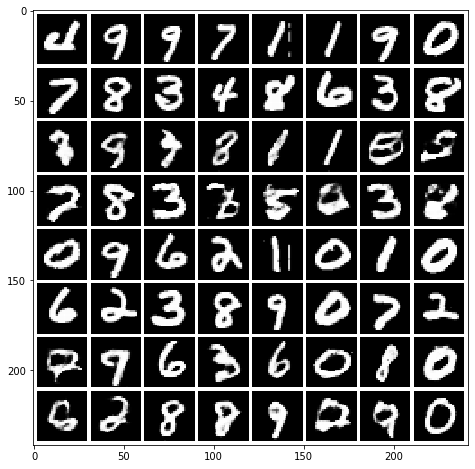

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07766101
Starting epoch 38


100%|██████████| 60000/60000 [00:41<00:00, 1457.31it/s, d_loss=0.00567, g_loss=118, mse=0.0795]


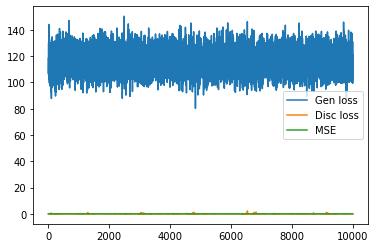

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


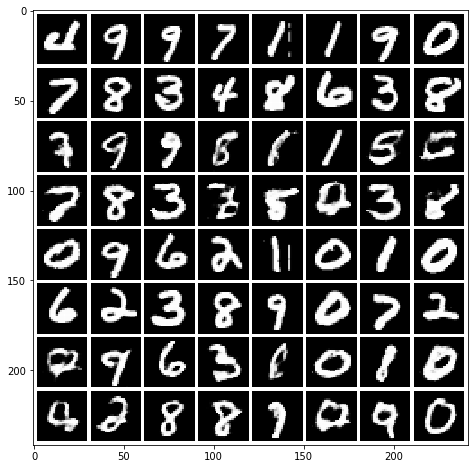

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07817804
Starting epoch 39


100%|██████████| 60000/60000 [00:39<00:00, 1512.12it/s, d_loss=0.00279, g_loss=115, mse=0.0769]


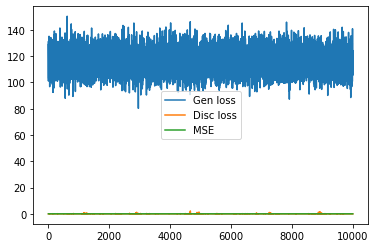

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


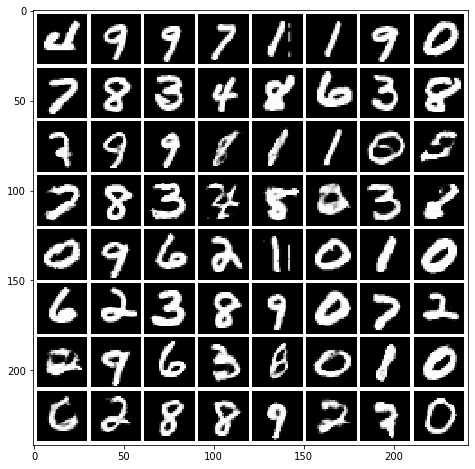

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076520875
Starting epoch 40


100%|██████████| 60000/60000 [00:41<00:00, 1461.06it/s, d_loss=0.00523, g_loss=118, mse=0.0795]


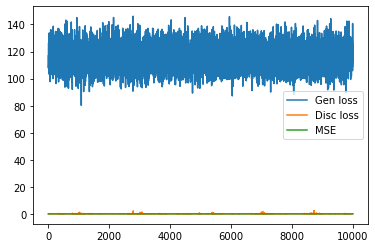

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


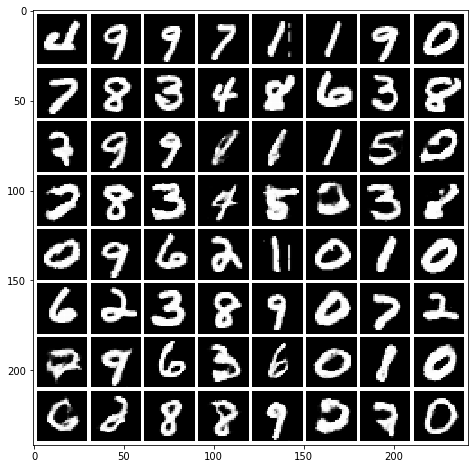

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07763035
Starting epoch 41


100%|██████████| 60000/60000 [00:41<00:00, 1461.47it/s, d_loss=0.0103, g_loss=117, mse=0.0789] 


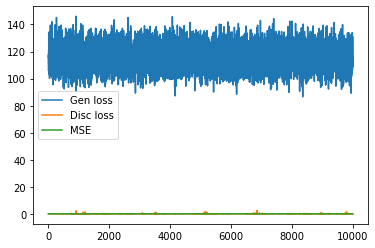

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


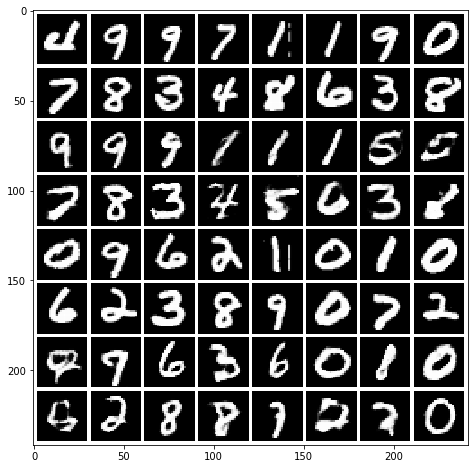

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07594866
Starting epoch 42


100%|██████████| 60000/60000 [00:40<00:00, 1468.93it/s, d_loss=0.00434, g_loss=116, mse=0.0781]


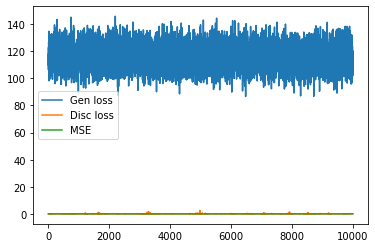

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


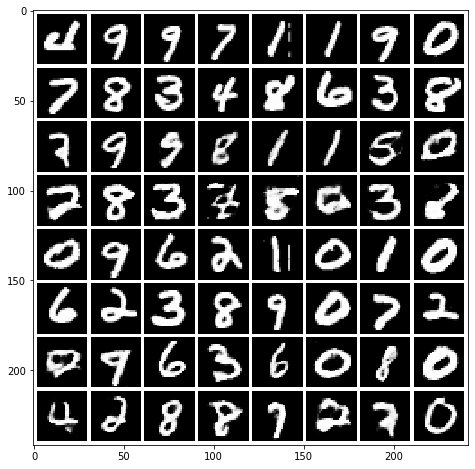

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077862546
Starting epoch 43


100%|██████████| 60000/60000 [00:41<00:00, 1446.98it/s, d_loss=0.1, g_loss=114, mse=0.0772]    


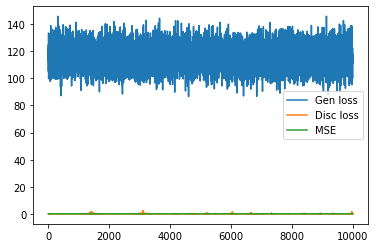

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


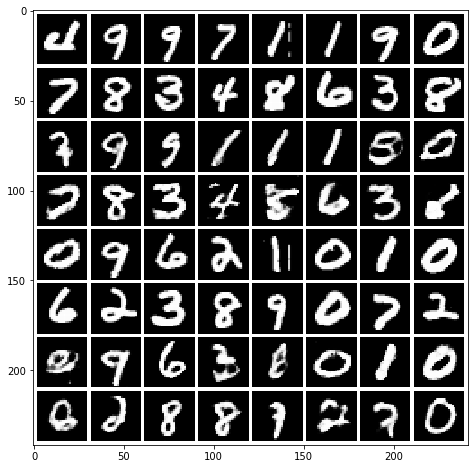

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076743804
Starting epoch 44


100%|██████████| 60000/60000 [00:41<00:00, 1457.54it/s, d_loss=0.0238, g_loss=115, mse=0.0781] 


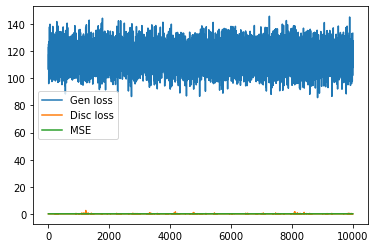

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


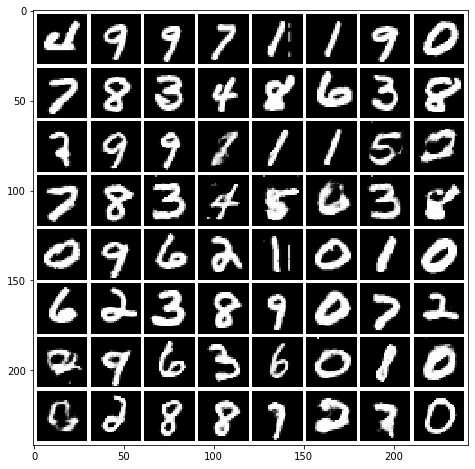

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077617906
Starting epoch 45


100%|██████████| 60000/60000 [00:41<00:00, 1437.04it/s, d_loss=0.00899, g_loss=117, mse=0.079] 


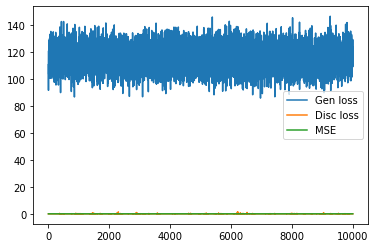

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


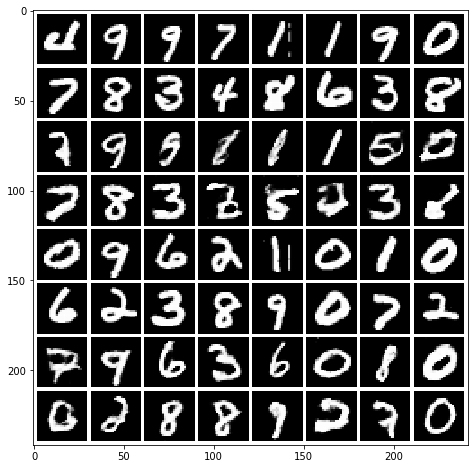

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07737197
Starting epoch 46


100%|██████████| 60000/60000 [00:41<00:00, 1537.36it/s, d_loss=0.0168, g_loss=115, mse=0.0773] 


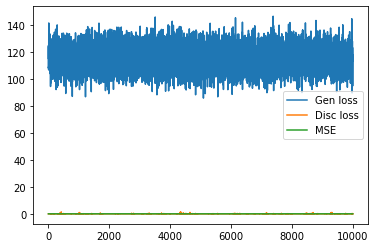

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


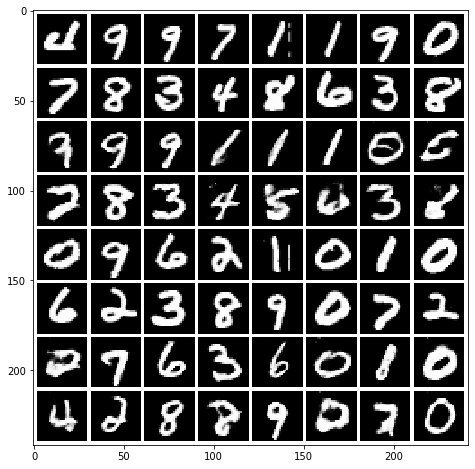

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07756097
Starting epoch 47


100%|██████████| 60000/60000 [00:41<00:00, 1458.57it/s, d_loss=0.0163, g_loss=114, mse=0.0771] 


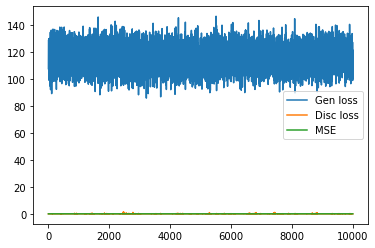

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


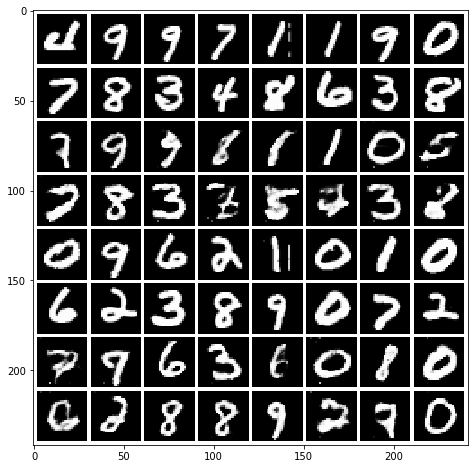

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07751936
Starting epoch 48


100%|██████████| 60000/60000 [00:41<00:00, 1463.28it/s, d_loss=0.00508, g_loss=115, mse=0.0771]


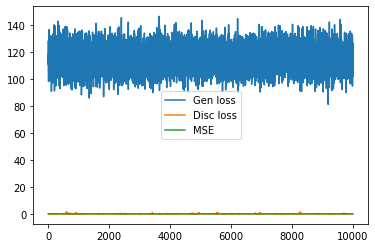

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


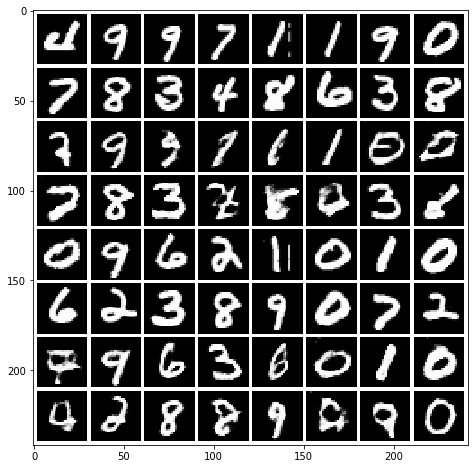

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077271625
Starting epoch 49


100%|██████████| 60000/60000 [00:41<00:00, 1461.27it/s, d_loss=0.00497, g_loss=115, mse=0.0773]


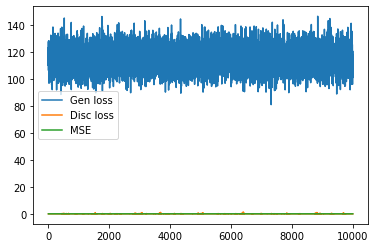

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


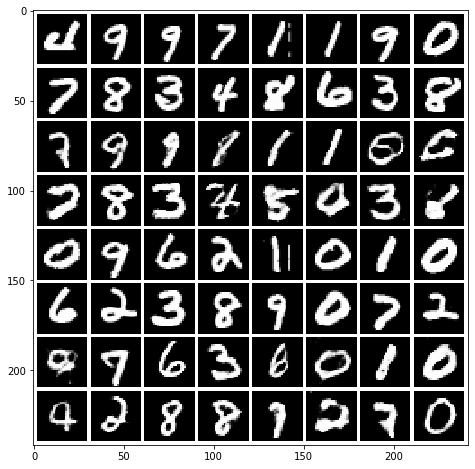

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07633893
Starting epoch 50


100%|██████████| 60000/60000 [00:41<00:00, 1443.77it/s, d_loss=0.00484, g_loss=115, mse=0.0771]


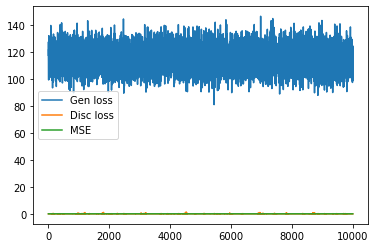

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


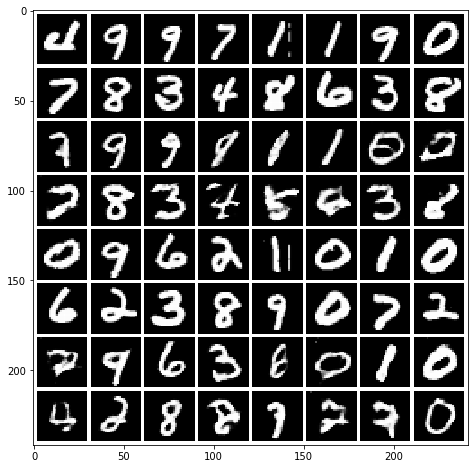

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077048935
Starting epoch 51


100%|██████████| 60000/60000 [00:41<00:00, 1445.15it/s, d_loss=0.00815, g_loss=117, mse=0.0787]


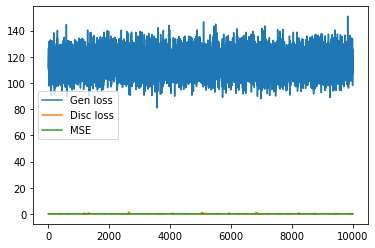

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


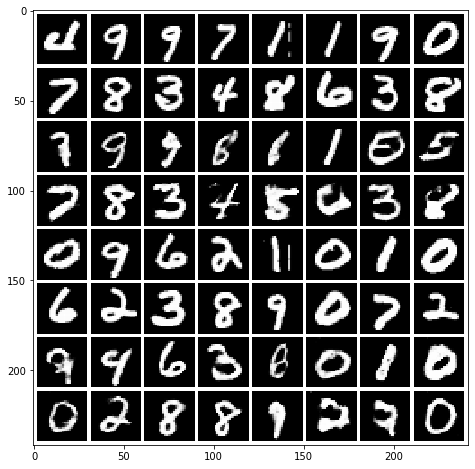

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077132836
Starting epoch 52


100%|██████████| 60000/60000 [00:40<00:00, 1439.96it/s, d_loss=0.00635, g_loss=115, mse=0.0773]


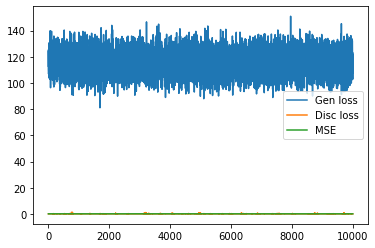

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


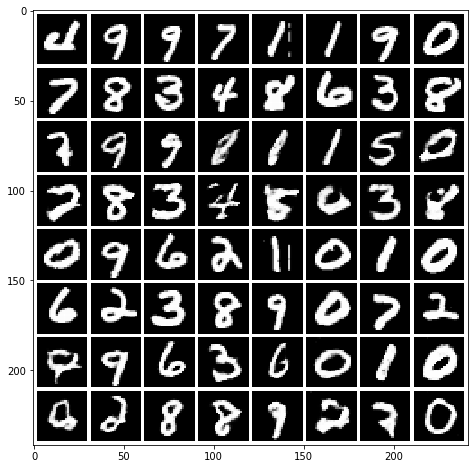

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076789126
Starting epoch 53


100%|██████████| 60000/60000 [00:40<00:00, 1475.00it/s, d_loss=0.0117, g_loss=116, mse=0.0782] 


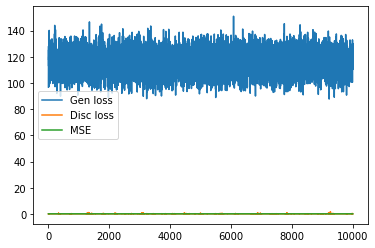

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


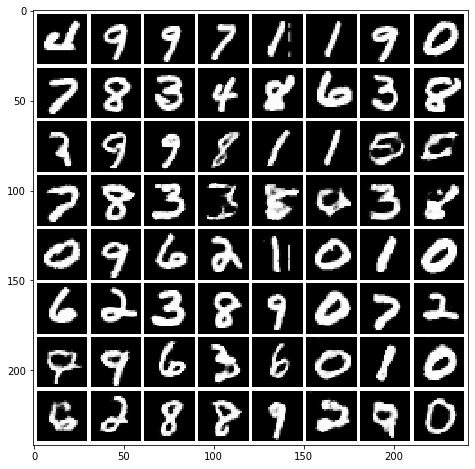

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07733658
Starting epoch 54


100%|██████████| 60000/60000 [00:40<00:00, 1480.20it/s, d_loss=0.00332, g_loss=115, mse=0.0771]


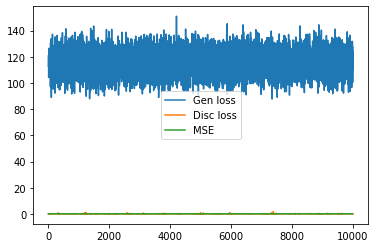

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


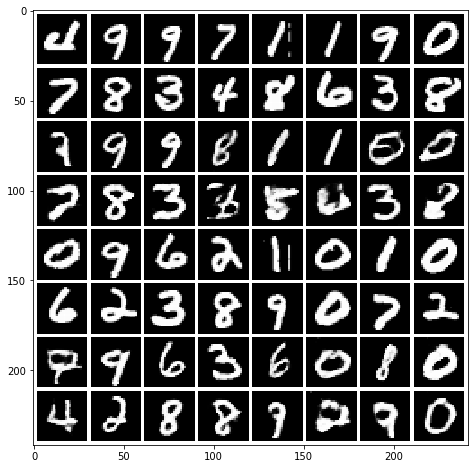

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07722673
Starting epoch 55


100%|██████████| 60000/60000 [00:39<00:00, 1500.07it/s, d_loss=0.0114, g_loss=115, mse=0.0766] 


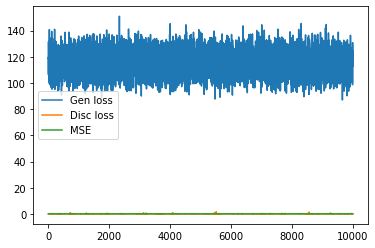

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


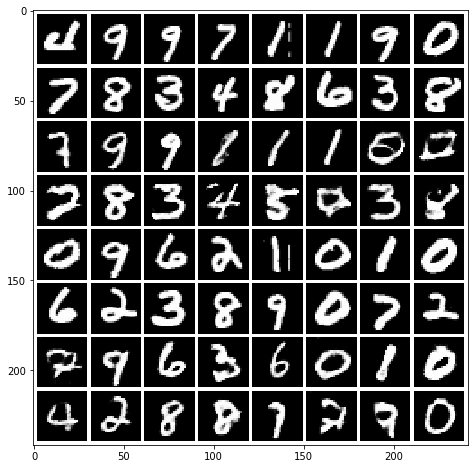

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07787195
Starting epoch 56


100%|██████████| 60000/60000 [00:40<00:00, 1495.17it/s, d_loss=0.00697, g_loss=116, mse=0.078] 


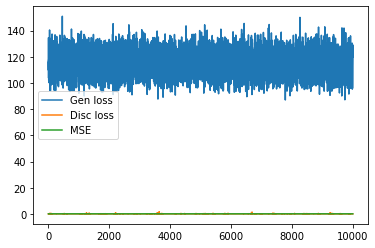

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


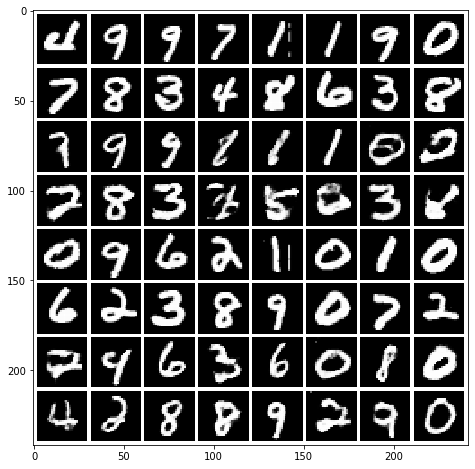

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07820202
Starting epoch 57


100%|██████████| 60000/60000 [00:40<00:00, 1476.01it/s, d_loss=0.0136, g_loss=116, mse=0.078]  


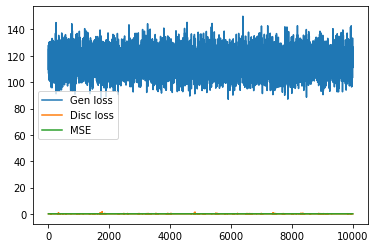

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


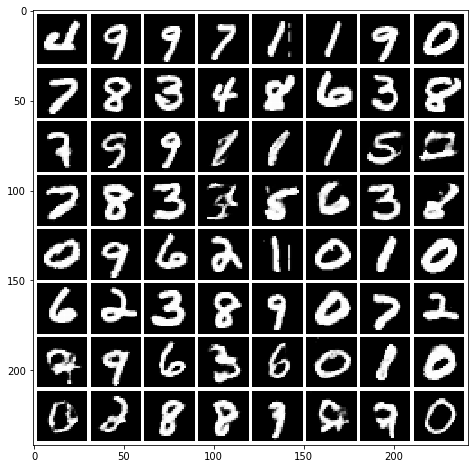

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077625975
Starting epoch 58


100%|██████████| 60000/60000 [00:40<00:00, 1468.27it/s, d_loss=0.00247, g_loss=116, mse=0.0777]


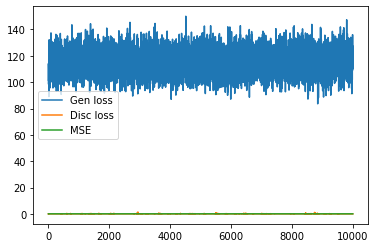

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


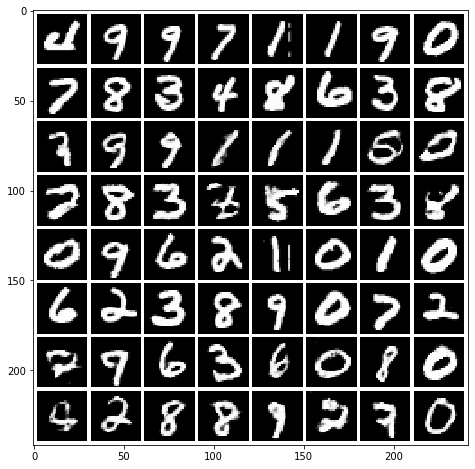

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07742011
Starting epoch 59


100%|██████████| 60000/60000 [00:41<00:00, 1458.20it/s, d_loss=0.0224, g_loss=115, mse=0.0772] 


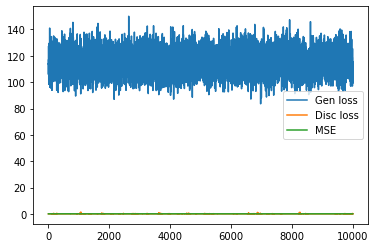

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


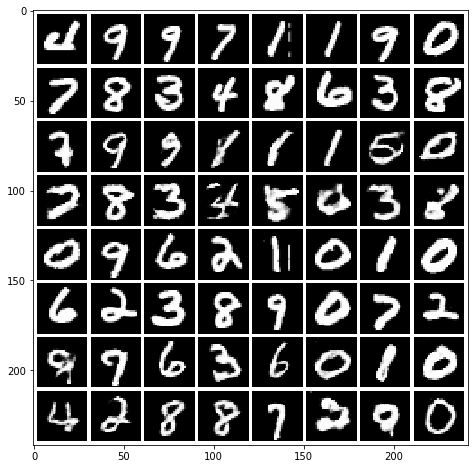

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077181526
Starting epoch 60


100%|██████████| 60000/60000 [00:41<00:00, 1447.88it/s, d_loss=0.00437, g_loss=116, mse=0.0773]


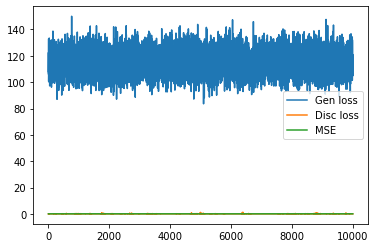

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


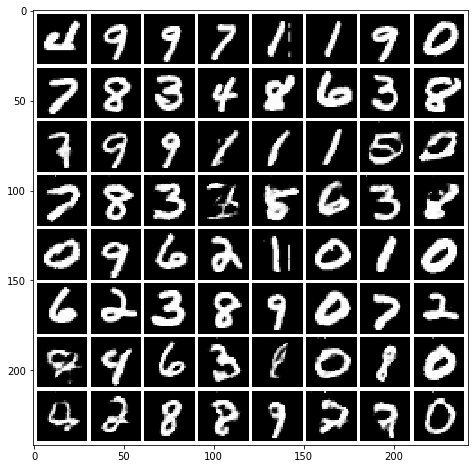

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07620863
Starting epoch 61


100%|██████████| 60000/60000 [00:41<00:00, 1457.31it/s, d_loss=0.00339, g_loss=114, mse=0.0755]


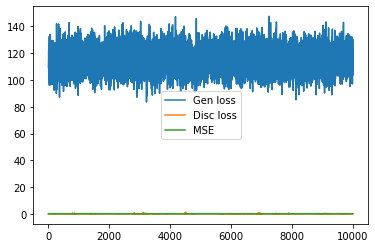

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


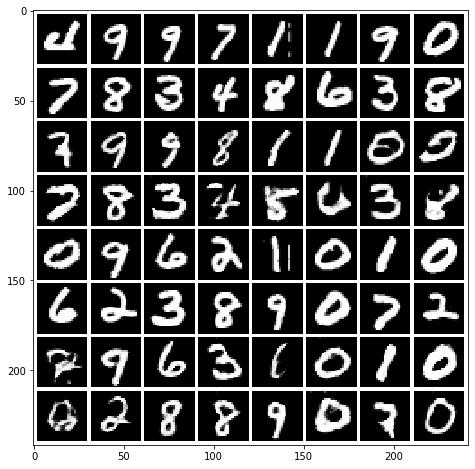

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07732787
Starting epoch 62


100%|██████████| 60000/60000 [00:40<00:00, 1437.47it/s, d_loss=0.00836, g_loss=114, mse=0.0764]


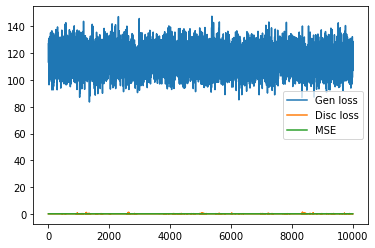

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


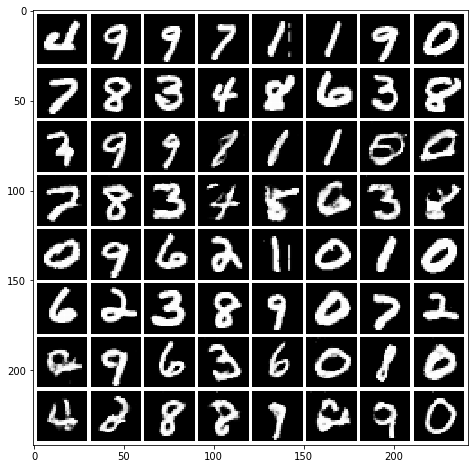

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07702566
Starting epoch 63


100%|██████████| 60000/60000 [00:41<00:00, 1453.53it/s, d_loss=0.00181, g_loss=114, mse=0.0758]


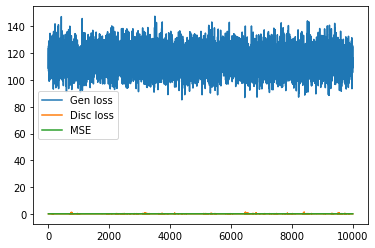

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


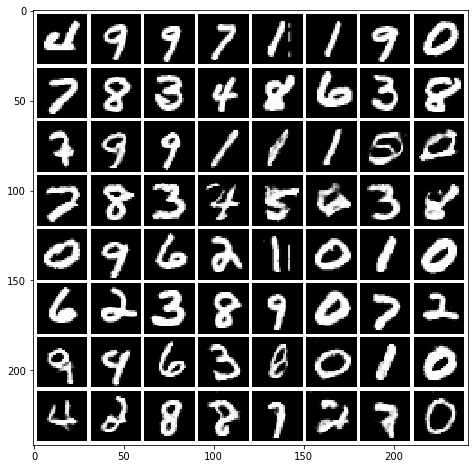

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07645373
Starting epoch 64


100%|██████████| 60000/60000 [00:41<00:00, 1447.91it/s, d_loss=0.0103, g_loss=116, mse=0.0781] 


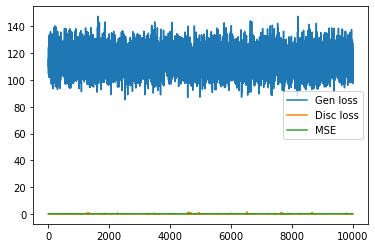

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


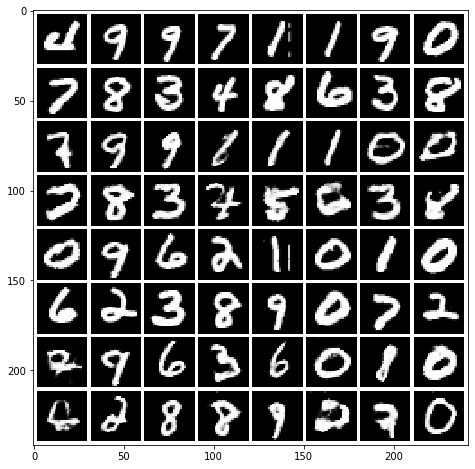

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07703213
Starting epoch 65


100%|██████████| 60000/60000 [00:40<00:00, 1460.72it/s, d_loss=0.0139, g_loss=114, mse=0.0766] 


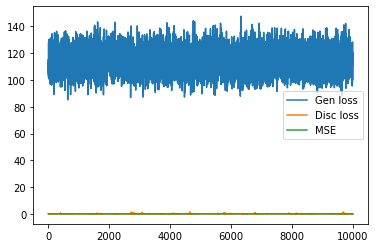

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


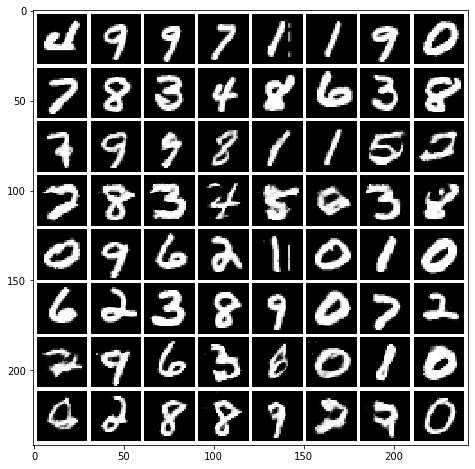

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07704723
Starting epoch 66


100%|██████████| 60000/60000 [00:41<00:00, 1462.56it/s, d_loss=0.00397, g_loss=115, mse=0.0767]


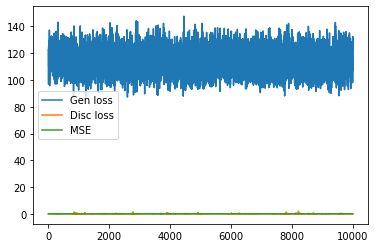

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


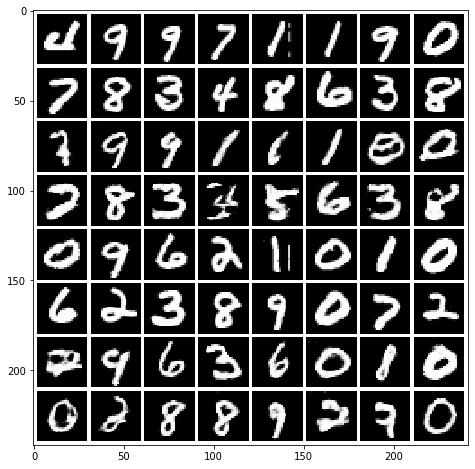

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07694813
Starting epoch 67


100%|██████████| 60000/60000 [00:41<00:00, 1441.79it/s, d_loss=0.0115, g_loss=114, mse=0.0761] 


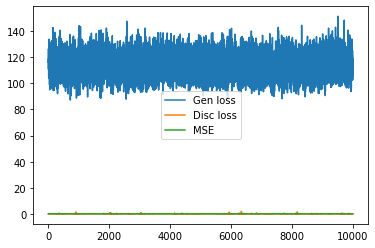

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


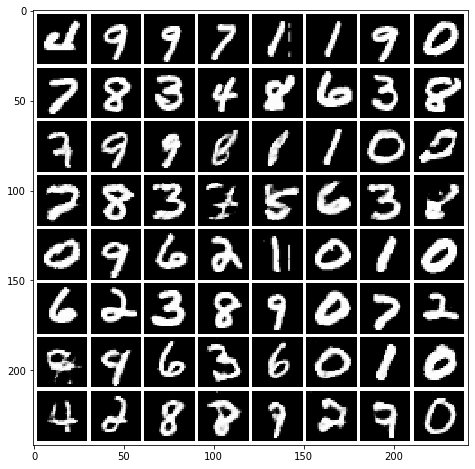

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07691204
Starting epoch 68


100%|██████████| 60000/60000 [00:41<00:00, 1441.32it/s, d_loss=0.0151, g_loss=114, mse=0.0757] 


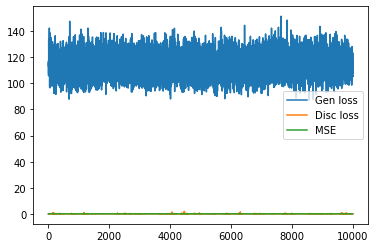

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


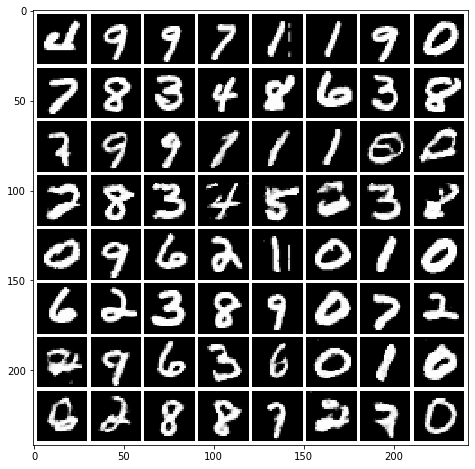

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0766999
Starting epoch 69


100%|██████████| 60000/60000 [00:41<00:00, 1444.49it/s, d_loss=0.00497, g_loss=115, mse=0.0768]


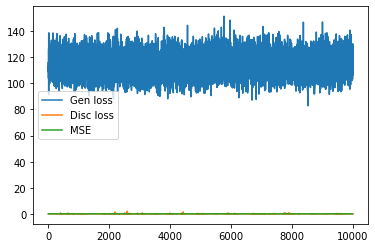

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


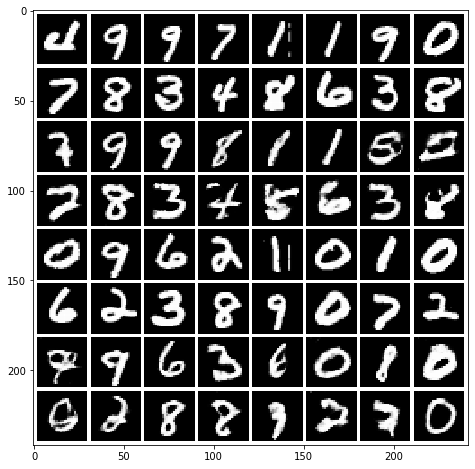

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0776678
Starting epoch 70


100%|██████████| 60000/60000 [00:41<00:00, 1455.54it/s, d_loss=0.0171, g_loss=114, mse=0.0759] 


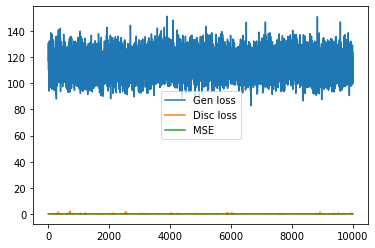

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


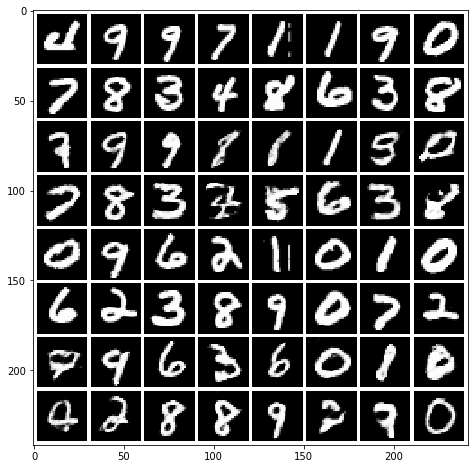

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076332115
Starting epoch 71


100%|██████████| 60000/60000 [00:41<00:00, 1452.40it/s, d_loss=0.00512, g_loss=114, mse=0.0764]


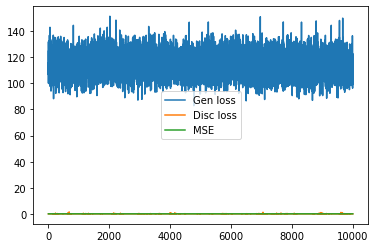

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


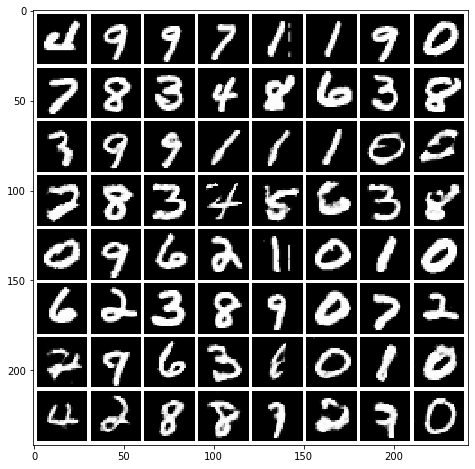

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077047266
Starting epoch 72


100%|██████████| 60000/60000 [00:41<00:00, 1432.46it/s, d_loss=0.0249, g_loss=114, mse=0.0772] 


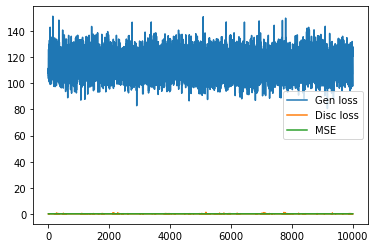

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


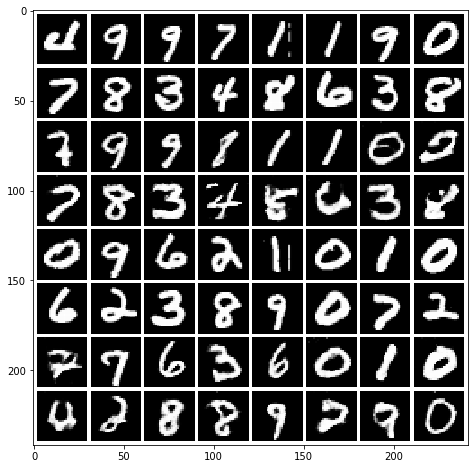

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07725674
Starting epoch 73


100%|██████████| 60000/60000 [00:41<00:00, 1404.80it/s, d_loss=0.0138, g_loss=115, mse=0.0767] 


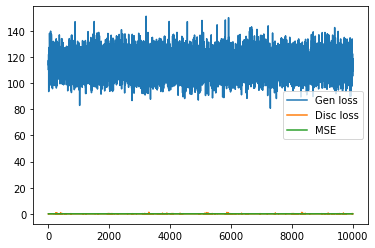

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


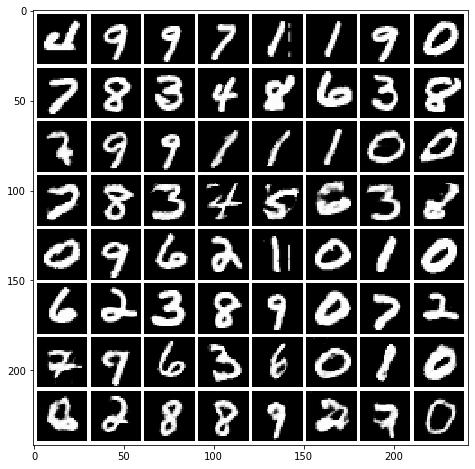

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07641059
Starting epoch 74


100%|██████████| 60000/60000 [00:40<00:00, 1437.05it/s, d_loss=0.00622, g_loss=114, mse=0.0758]


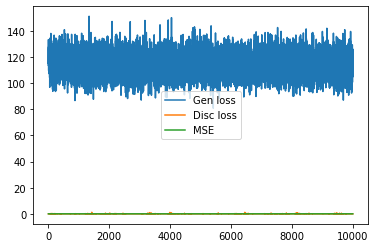

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


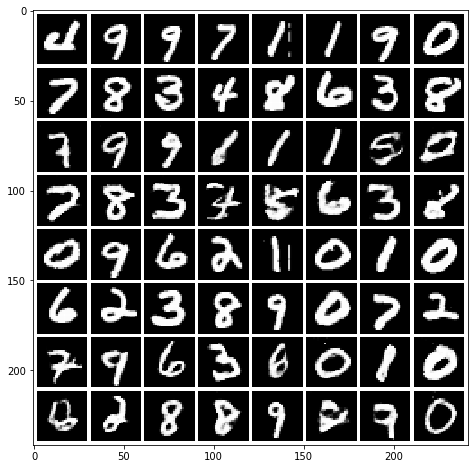

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07697634
Starting epoch 75


100%|██████████| 60000/60000 [00:41<00:00, 1457.67it/s, d_loss=0.00325, g_loss=115, mse=0.0759]


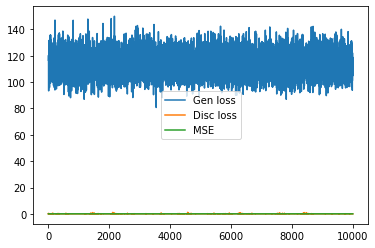

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


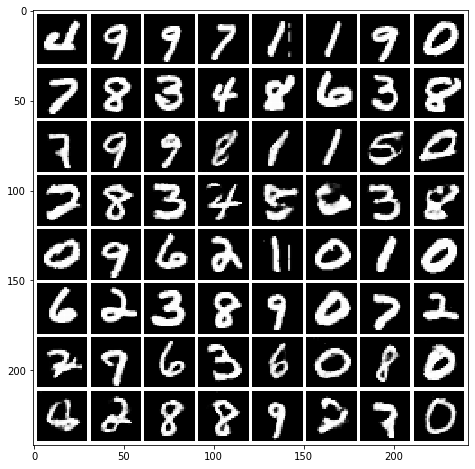

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07728048
Starting epoch 76


100%|██████████| 60000/60000 [00:41<00:00, 1447.44it/s, d_loss=0.0326, g_loss=110, mse=0.073]  


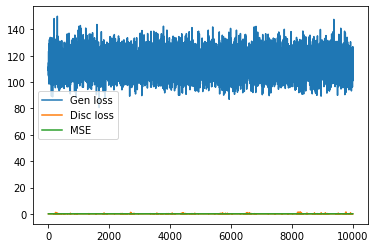

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


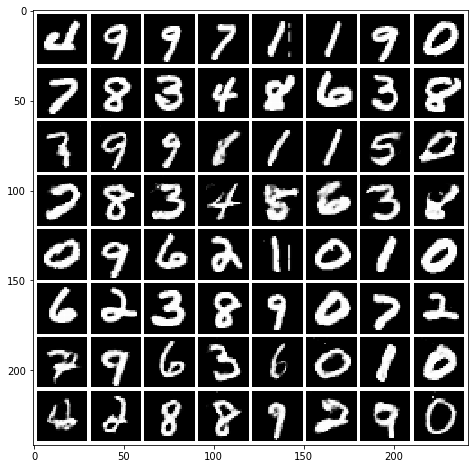

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076985046
Starting epoch 77


100%|██████████| 60000/60000 [00:41<00:00, 1457.50it/s, d_loss=0.00986, g_loss=113, mse=0.0753]


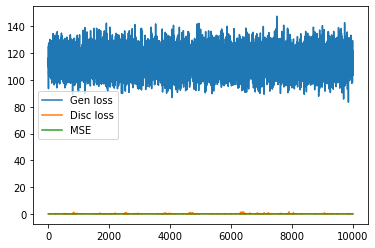

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


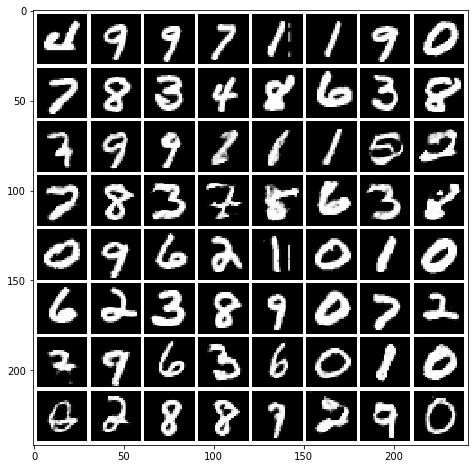

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07711791
Starting epoch 78


100%|██████████| 60000/60000 [00:41<00:00, 1424.88it/s, d_loss=0.00483, g_loss=114, mse=0.0751]


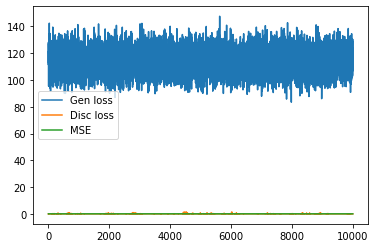

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


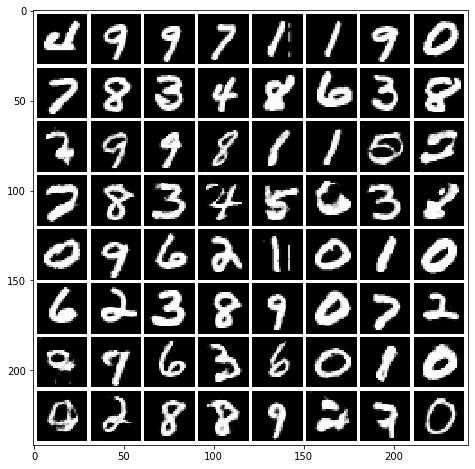

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07673499
Starting epoch 79


100%|██████████| 60000/60000 [00:41<00:00, 1460.29it/s, d_loss=0.0433, g_loss=113, mse=0.0757] 


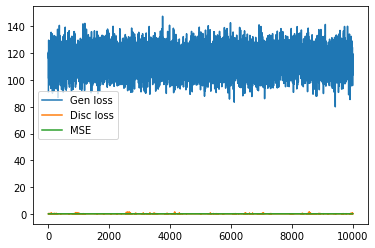

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


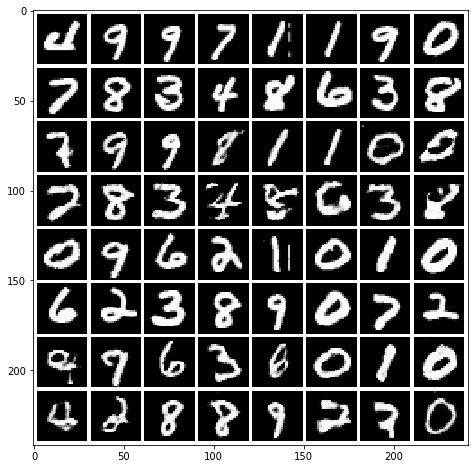

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07668663
Starting epoch 80


100%|██████████| 60000/60000 [00:41<00:00, 1457.12it/s, d_loss=0.0117, g_loss=114, mse=0.0761] 


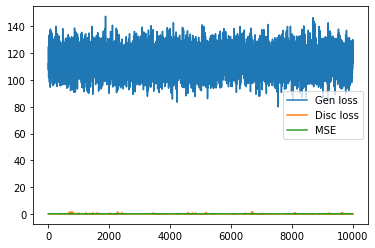

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


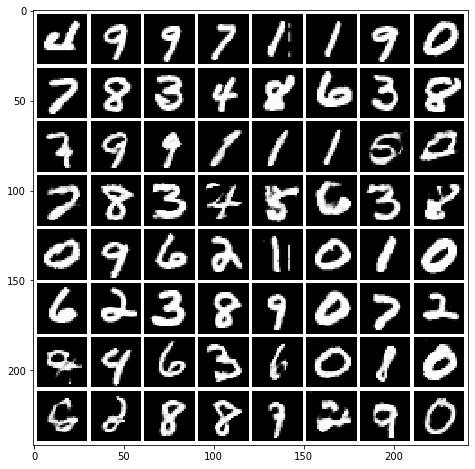

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07762732
Starting epoch 81


100%|██████████| 60000/60000 [00:41<00:00, 1462.97it/s, d_loss=0.0365, g_loss=113, mse=0.0755] 


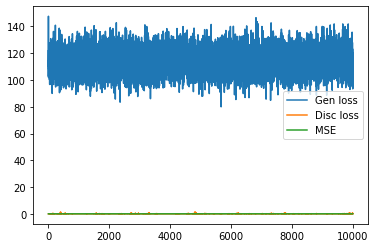

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


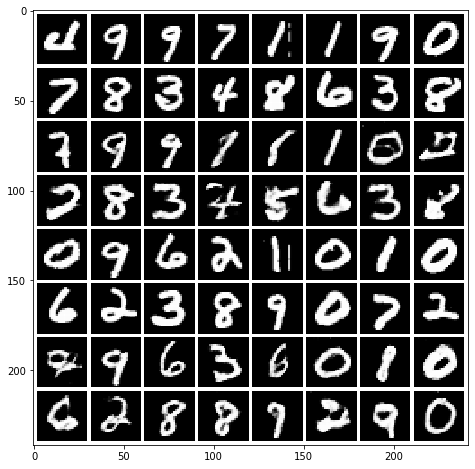

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07750687
Starting epoch 82


100%|██████████| 60000/60000 [00:41<00:00, 1454.23it/s, d_loss=0.00799, g_loss=113, mse=0.0748]


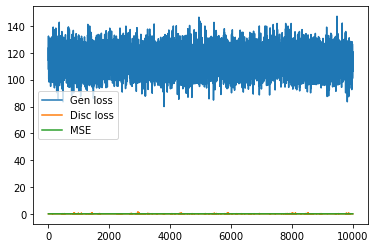

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


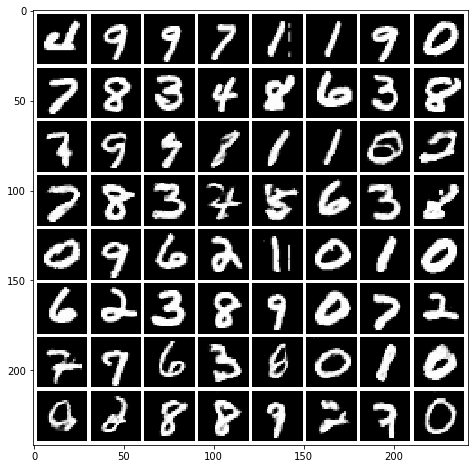

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07644158
Starting epoch 83


100%|██████████| 60000/60000 [00:41<00:00, 1436.32it/s, d_loss=0.00221, g_loss=113, mse=0.0749]


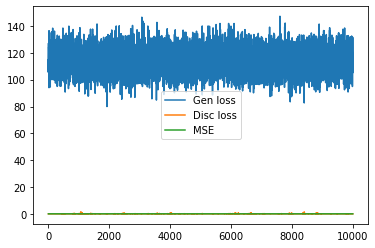

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


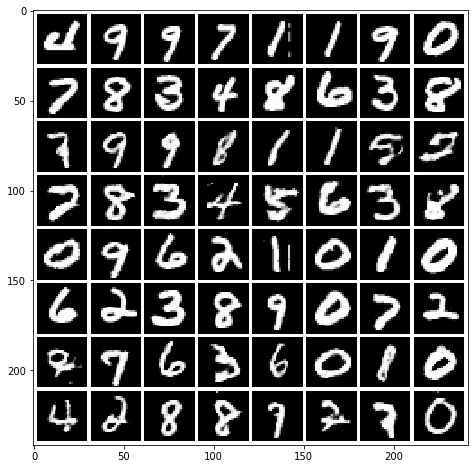

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07717287
Starting epoch 84


100%|██████████| 60000/60000 [00:41<00:00, 1448.96it/s, d_loss=0.00358, g_loss=116, mse=0.0764]


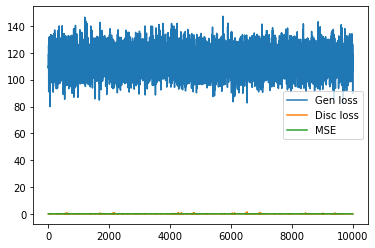

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


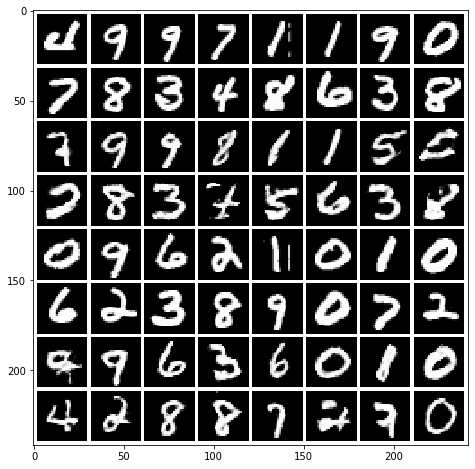

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07686699
Starting epoch 85


100%|██████████| 60000/60000 [00:41<00:00, 1459.11it/s, d_loss=0.00328, g_loss=115, mse=0.0762]


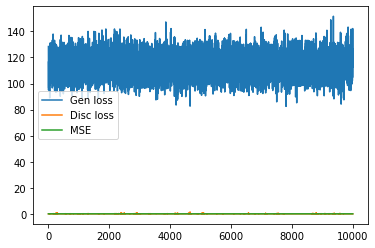

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


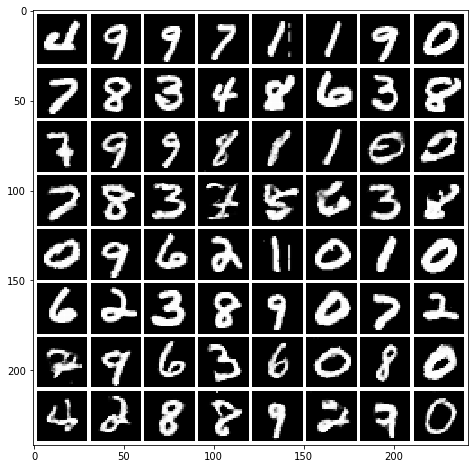

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.0782703
Starting epoch 86


100%|██████████| 60000/60000 [00:41<00:00, 1455.57it/s, d_loss=0.00934, g_loss=113, mse=0.0746]


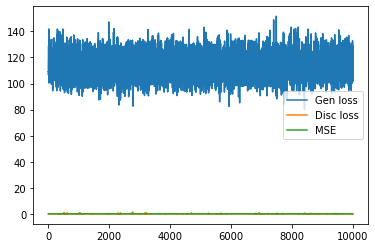

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


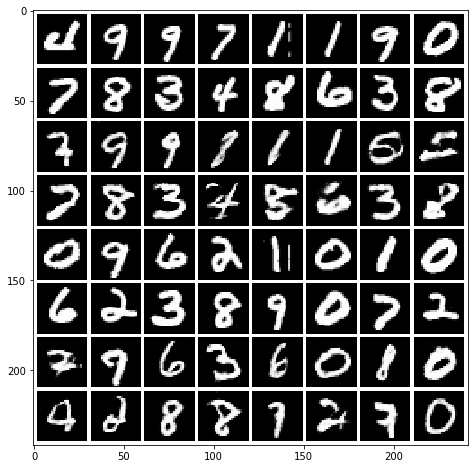

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07715315
Starting epoch 87


100%|██████████| 60000/60000 [00:41<00:00, 1448.76it/s, d_loss=0.0129, g_loss=113, mse=0.0749] 


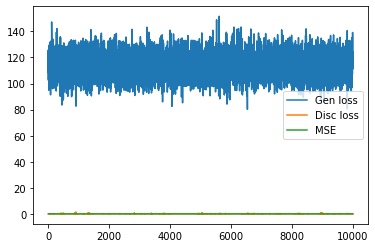

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


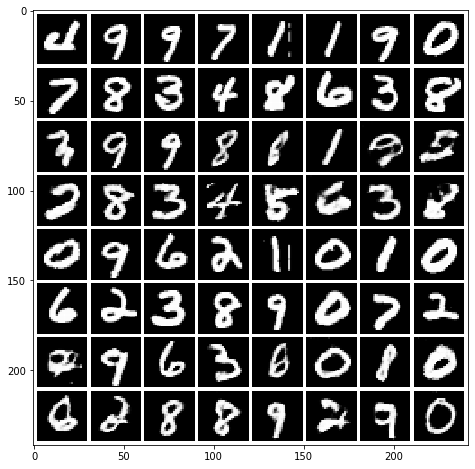

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076543204
Starting epoch 88


100%|██████████| 60000/60000 [00:41<00:00, 1459.41it/s, d_loss=0.0219, g_loss=112, mse=0.074]  


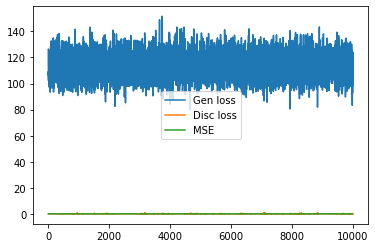

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


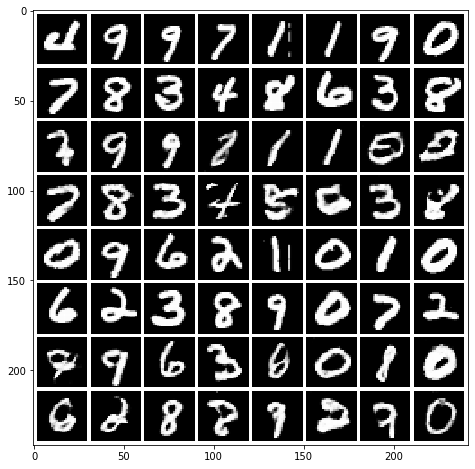

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07723563
Starting epoch 89


100%|██████████| 60000/60000 [00:41<00:00, 1452.06it/s, d_loss=0.00861, g_loss=115, mse=0.0758]


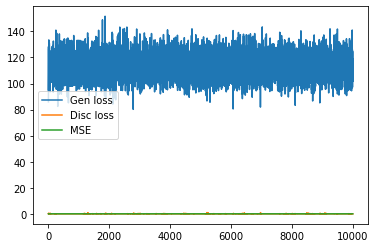

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


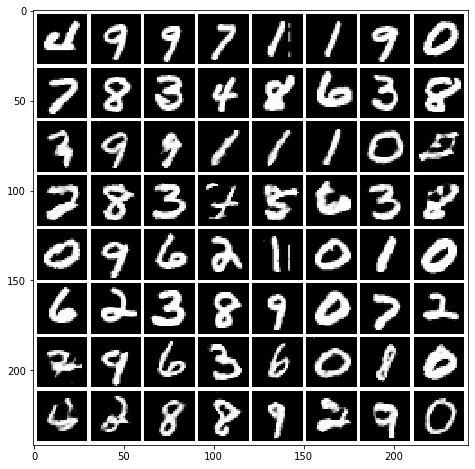

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07737284
Starting epoch 90


100%|██████████| 60000/60000 [00:41<00:00, 1442.02it/s, d_loss=0.0259, g_loss=114, mse=0.0755] 


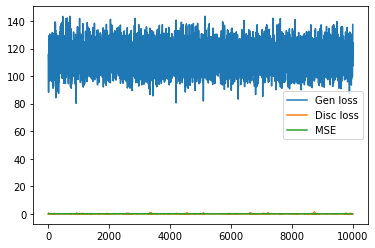

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


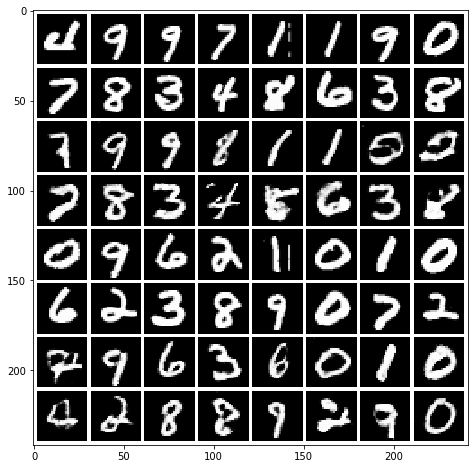

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07639945
Starting epoch 91


100%|██████████| 60000/60000 [00:41<00:00, 1450.89it/s, d_loss=0.00331, g_loss=115, mse=0.0765]


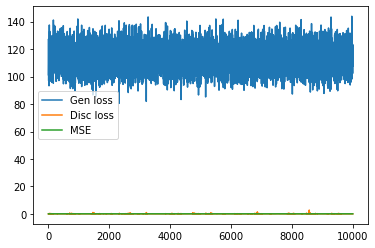

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


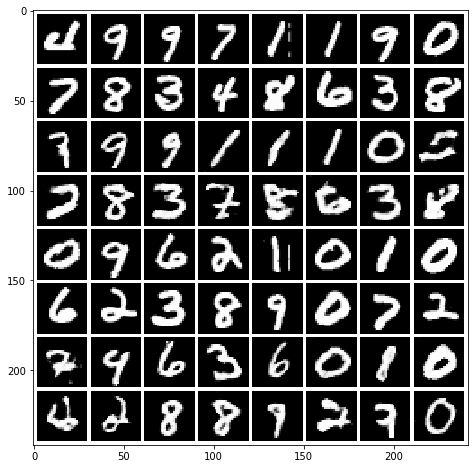

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.076925814
Starting epoch 92


100%|██████████| 60000/60000 [00:41<00:00, 1454.22it/s, d_loss=0.0279, g_loss=114, mse=0.0762] 


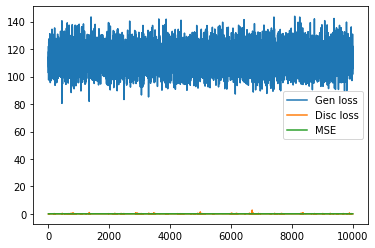

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


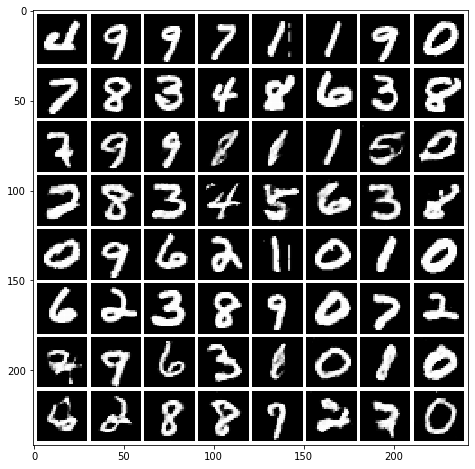

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07807448
Starting epoch 93


100%|██████████| 60000/60000 [00:41<00:00, 1449.32it/s, d_loss=0.0059, g_loss=112, mse=0.0738] 


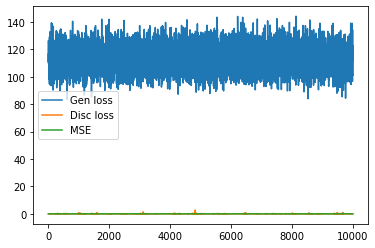

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


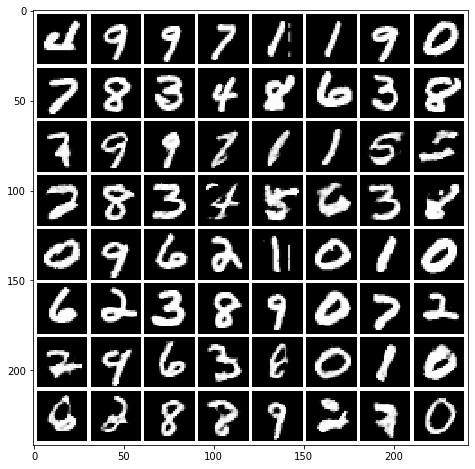

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.075823575
Starting epoch 94


100%|██████████| 60000/60000 [00:41<00:00, 1462.45it/s, d_loss=0.00423, g_loss=113, mse=0.0748] 


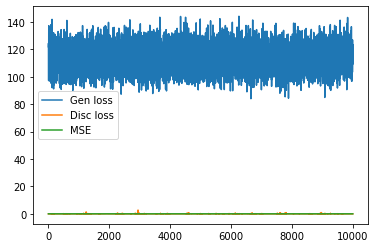

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


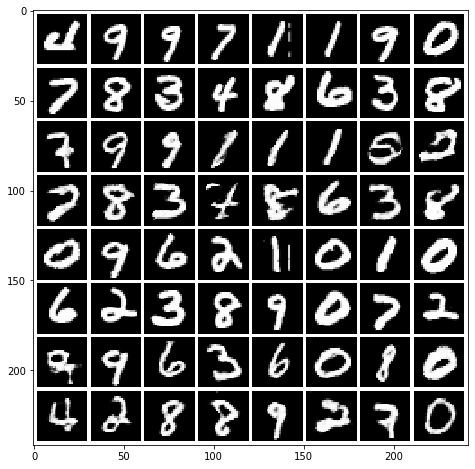

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07768185
Starting epoch 95


100%|██████████| 60000/60000 [00:41<00:00, 1432.18it/s, d_loss=0.00475, g_loss=115, mse=0.0757]


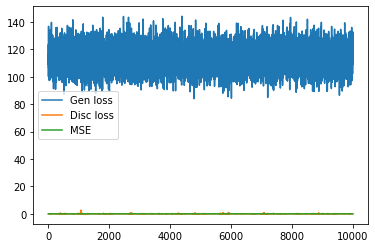

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


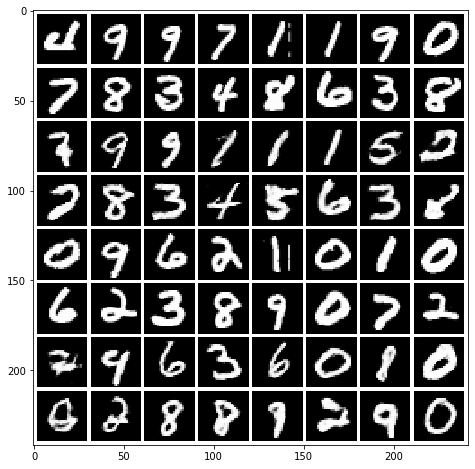

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07621309
Starting epoch 96


100%|██████████| 60000/60000 [00:41<00:00, 1458.34it/s, d_loss=0.0294, g_loss=115, mse=0.0764] 


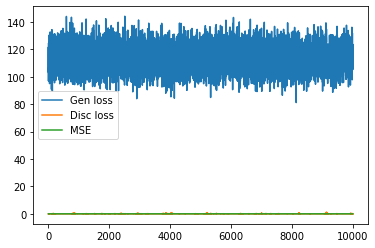

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


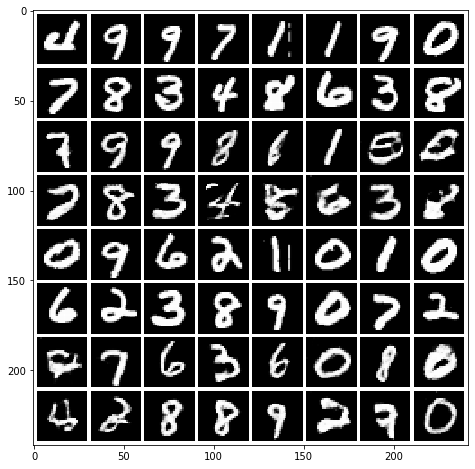

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.077149406
Starting epoch 97


100%|██████████| 60000/60000 [00:41<00:00, 1456.17it/s, d_loss=0.00243, g_loss=114, mse=0.0757]


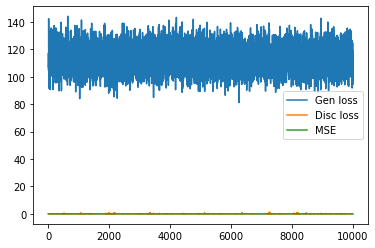

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


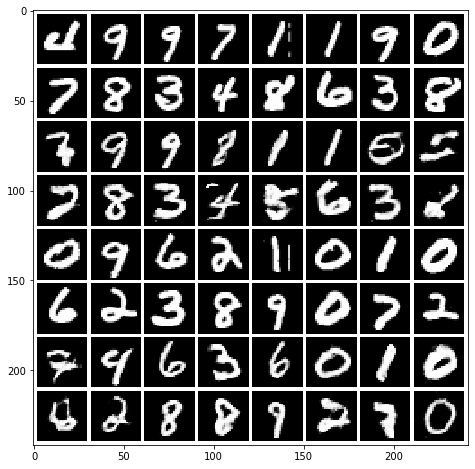

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07659042
Starting epoch 98


100%|██████████| 60000/60000 [00:41<00:00, 1453.26it/s, d_loss=0.00298, g_loss=115, mse=0.0761]


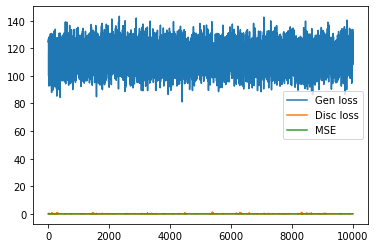

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


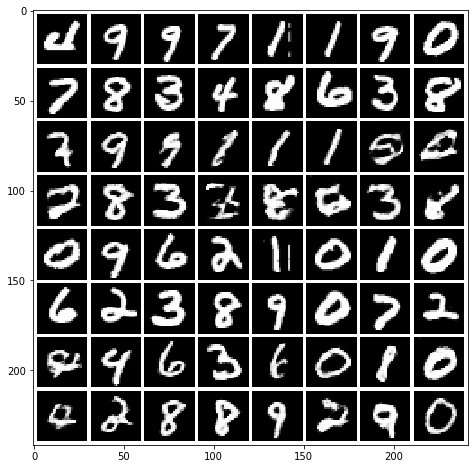

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07658548
Starting epoch 99


100%|██████████| 60000/60000 [00:41<00:00, 1477.70it/s, d_loss=0.0963, g_loss=111, mse=0.0732] 


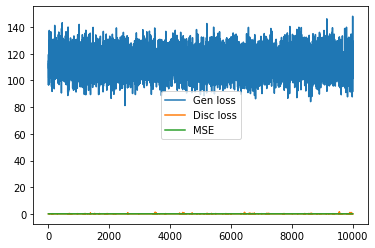

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


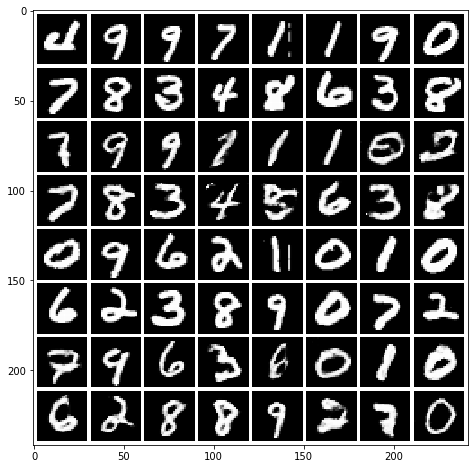

  0%|          | 0/60000 [00:00<?, ?it/s]

MSE validation: 0.07673328
Starting epoch 100


100%|██████████| 60000/60000 [00:41<00:00, 1453.24it/s, d_loss=0.0082, g_loss=113, mse=0.0745] 


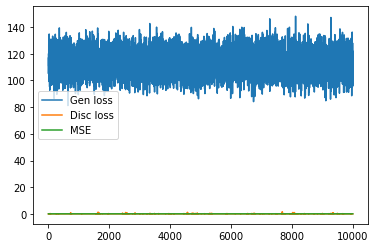

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


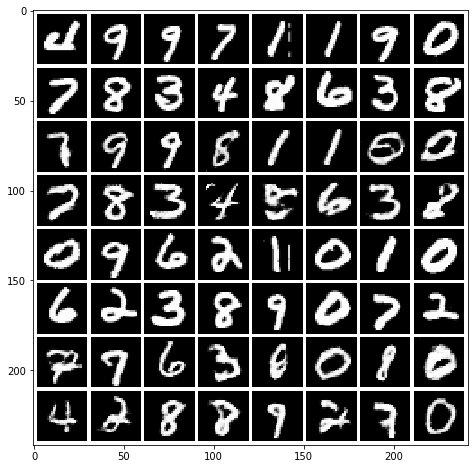

MSE validation: 0.076520026


In [12]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/cGAN/Ameas10FCGenerator2048MNIST_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))
torch.save(disc_weights, "../cache/cGAN/Ameas10ConvDiscriminator64MNIST_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [36]:
### LOAD MODEL ####

m = 10

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)
print(A.shape)

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_MNIST/Ameas{}FCGenerator2048MNIST_0100.sd".format(m), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/cGAN/Ameas200ConvDiscriminator64Fashion_0100_20190927_002846.sd", map_location={'cuda:1': device.__str__()}));

torch.Size([784, 10])
Version 0.4


In [37]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, dataloader['test'])
print(test_images.shape)

(8000, 1, 28, 28)


In [38]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_images, open("/home/shared/phase-retrieval/test/cGAN_MNIST/Ameas{}_cganrand_4_1024_original.p".format(m), "wb"))
pickle.dump(test_outputs, open("/home/shared/phase-retrieval/test/cGAN_MNIST/Ameas{}_cganrand_4_1024.p".format(m), "wb"))

In [22]:
### LOAD RESULTS ###
import pickle

test_images = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/Ameas{}_cganrand_4_1024_original.p".format(m), "rb"))
test_outputs = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/Ameas{}_cganrand_4_1024.p".format(m), "rb"))

In [23]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.012874098228280673, std: 0.011062808599317858
  MAE: 0.051949868267001875, std: 0.026189681470321198
  SSIM: 0.7948762119009704, std: 0.13717516698827822
  Sharpness: 0.08094023097778824, std: 0.0367198238053373
  PhCo-MSE: 0.014137518672328042, std: 0.015383226844812994
  PhCo-MAE: 0.05404883086794143, std: 0.03169440758841217
  PhCo-SSIM: 0.7858506223819215, std: 0.1579270353237938
  CroCo-MSE: 0.012824374657725457, std: 0.01096747679901523
  CroCo-MAE: 0.051883565353818994, std: 0.026087760472509963
  CroCo-SSIM: 0.7954567778338133, std: 0.13617395176601668

Magnitude error:
  MSE Magnitude: 3.8638532019011587, std: 3.2292010304819208

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01287 | 0.05195 | 0.7949 | 0.08094 | 0.01414 | 0.05405 | 0.7859 | 0.01282 | 0.05188 | 0.7955 | 3.864 |


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


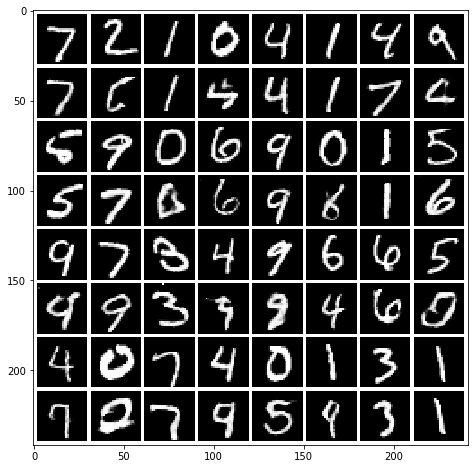

In [15]:
# Print test predictions 2 #

to_plot = np.stack([test_images[:32, 0].reshape(4, 8, 28, 28), 
                    test_outputs[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
                
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/Ameas10_4_1024.png")
#plot_grid(to_plot, figsize=(8,8))

#plot_grid(torch.Tensor(np.stack([test_images[:32, 0].reshape(4, 8, 28, 28), test_outputs[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)),
#          file='/home/shared/phase-retrieval/out/cgan/'+dataset+'/cgan{0}.pdf'.format(time.strftime("%Y%m%d_%H%M%S")))

## Evaluation for different cGAN models (random z and 1024 samples)


| Nr Type | epochs | m | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 100 | 784 | 0.009934 | 0.02885 | 0.9058 | 0.01019 | 0.02919 | 0.009915 | 3.054
| 4 | 100 | 500 | 0.01031 | 0.02931 | 0.9028 | 0.01056 | 0.02965 | 0.01030 | 3.186
| 4 | 100 | 300 | 0.01157 | 0.03141 | 0.8904 | 0.01197 | 0.03193 | 0.01155 | 3.589
| 4 | 100 | 200 | 0.01279 | 0.03295 | 0.8806 | 0.01332 | 0.03355 | 0.01277 | 3.945
| 4 | 100 | 100 | 0.01547 | 0.03698 | 0.8563 | 0.01609 | 0.03767 | 0.01541 | 4.666
| 4 | 100 | 50 | 0.02448 | 0.04824 | 0.7898 | 0.02729 | 0.05129 | 0.02390 | 7.218
| 4 | 100 | 25 | 0.04219 | 0.06913 | 0.6757 | 0.04620 | 0.07328 | 0.03944 | 11.81
| 4 | 100 | 10 | 0.07851 | 0.1085 | 0.4710 | 0.07895 | 0.1087 | 0.06626 | 20.42

In [11]:
# Latent z optimization

def genopt(sample_meas_pad, gen, device, steps=5000, lr=1.0):

    gen.to(device)
    gen.eval()

    z = torch.randn((sample_meas_pad.shape), requires_grad=True, device=device)    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_meas_pad], dim=1))
    
    for i in range(steps):
        _, meas_pad = calc_meas(last_out)

        mse_all = torch.mean((meas_pad - sample_meas_pad) ** 2, dim=(1, 2, 3))
        loss = torch.sum(mse_all)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(torch.cat([z, sample_meas_pad], dim=1))
        
        losses.append(loss.item())
    
    return last_out.detach(), losses, mse_all

Batch 1/1 finished


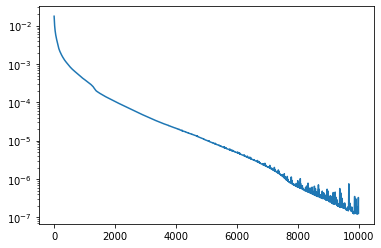

In [12]:
### Latent z optimization ###

num_batches = 1
batch_size = 32
steps = 10000
max_loss = 0.0
lr = 1e-2 # 1.0
###


out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    _, test_meas_pad = calc_meas(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    

    cur_out_results, cur_loss, cur_mse_all = genopt(sample_meas_pad=test_meas_pad, gen=gen,
                                                    device=device, steps=steps, lr=lr)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [23]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_MNIST/Ameas10_cgan_4_1024_original.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_MNIST/Ameas10_cgan_4_1024.p", "wb"))

In [24]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_MNIST/Ameas10_cgan_4_1024_original.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_MNIST/Ameas10_cgan_4_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


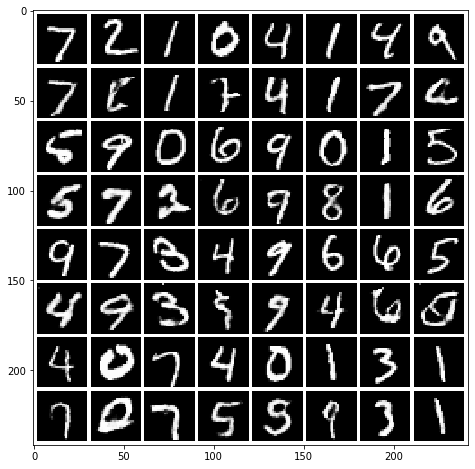

Signal error:
  MSE: 0.07921547305642775, std: 0.04297430731566074
  MAE: 0.11002706572126794, std: 0.049744830125736085
  SSIM: 0.46321393453281284, std: 0.2346545333985733
  FASI-MSE: 0.07943857980479531, std: 0.04166787584257192
  FASI-MAE: 0.10996742359722853, std: 0.04839970774388297
  COCO-MSE: 0.06695204009525768, std: 0.03371363322020794

Magnitude error:
  MSE Magnitude: 20.59450003980249, std: 11.402188100442741

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [25]:
print("Output under minimized magnitude distance:")
to_plot = torch.Tensor(np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                                 out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28))
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/mnist/Ameas10_4_1024_10000latentSteps.png")
#plot_grid(to_plot, figsize=(8, 8))

benchmark(pred=out_results, true=out_original, check_all=True)

## Final Evaluation (1024 samples)

lr checked for what works best on 1 batch

| Nr Type | iterations | lr | m | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 10000 | 1.0 | 784 | 0.0004936 | 0.005940 | 0.9952 | 0.0004937 | 0.005940 | 0.0004937 | 0.1912
| 4 | 10000 | 1.0 | 500 | 0.0004001 | 0.005453 | 0.9959 | 0.0004001 | 0.005453 | 0.0004001 | 0.1572
| 4 | 10000 | 1.0 | 300 | 0.0004493 | 0.005766 | 0.9953 | 0.0004493 | 0.005766 | 0.0004493 | 0.1734
| 4 | 10000 | 1.0 | 200 | 0.0007402 | 0.006641 | 0.9912 | 0.0007313 | 0.006620 | 0.0007313 | 0.2640
| 4 | 10000 | 1.0 | 100 | 0.006867 | 0.02242 | 0.9267 | 0.006946 | 0.02251 | 0.006839 | 2.216
| 4 | 10000 | 1e-1 | 50 | 0.02071 | 0.04507 | 0.8112 | 0.02192 | 0.04639 | 0.02035 | 6.0921
| 4 | 10000 | 1e-2 | 25 | 0.04203 | 0.07043 | 0.6699 | 0.04603 | 0.07464 | 0.03923 | 11.61
| 4 | 10000 | 1e-3 | 10 | 0.07922 | 0.1100 | 0.4632 | 0.07944 | 0.1100 | 0.06695 | 20.59


## Raw output

### Random z

m=784:

Signal error:
  MSE: 0.009933825234497817, std: 0.005274065621285168
  MAE: 0.028852450127487828, std: 0.010126864494064754
  SSIM: 0.9058275027688745, std: 0.04813007612018017
  FASI-MSE: 0.010190880784989531, std: 0.006045541598162565
  FASI-MAE: 0.029187612118221296, std: 0.01072493361000893
  COCO-MSE: 0.009914943246030032, std: 0.005266501227453251

Magnitude error:
  MSE Magnitude: 3.0535950655720105, std: 1.585076557646142


m=500:

Signal error:
  MSE: 0.010306922623954051, std: 0.00603455004508721
  MAE: 0.029312923021734605, std: 0.011231923976252988
  SSIM: 0.9027689130658189, std: 0.05417594113289698
  FASI-MSE: 0.010556694890624385, std: 0.006583415800314809
  FASI-MAE: 0.029649160343524272, std: 0.011728162646303992
  COCO-MSE: 0.010302253905370231, std: 0.006030108431926341

Magnitude error:
  MSE Magnitude: 3.1857526552570947, std: 1.83218002072363


m=300:

Signal error:
  MSE: 0.011573191471256905, std: 0.00692349864169105
  MAE: 0.031414094398314774, std: 0.012541469313389278
  SSIM: 0.890362798134712, std: 0.06313388992659019
  FASI-MSE: 0.011968449044616136, std: 0.007816639704705761
  FASI-MAE: 0.03192941510678793, std: 0.013304481580002482
  COCO-MSE: 0.011553487239960952, std: 0.0069040638601419145

Magnitude error:
  MSE Magnitude: 3.589345867581189, std: 2.0516377366209566


m=200:

Signal error:
  MSE: 0.012791165551220729, std: 0.008153325702186506
  MAE: 0.032945651567843015, std: 0.01397057749437139
  SSIM: 0.8806167729676289, std: 0.0729113048517571
  FASI-MSE: 0.013318777936206061, std: 0.009896678034359431
  FASI-MAE: 0.03355092031279128, std: 0.015473040718377613
  COCO-MSE: 0.012766691370538076, std: 0.008111277043258569

Magnitude error:
  MSE Magnitude: 3.945088656206315, std: 2.537249207052089


m=100:

Signal error:
  MSE: 0.01547355293223518, std: 0.010237213317149446
  MAE: 0.036982914602504025, std: 0.01644631209884679
  SSIM: 0.8563418281051941, std: 0.0890644072194497
  FASI-MSE: 0.016090774546228204, std: 0.011817847267933734
  FASI-MAE: 0.03767255753109566, std: 0.017827118527073783
  COCO-MSE: 0.015412072840485489, std: 0.01014321507126043

Magnitude error:
  MSE Magnitude: 4.6658982914717955, std: 2.974625750110005


m=50:

Signal error:
  MSE: 0.024481491802703204, std: 0.018314510325430564
  MAE: 0.048244135552522494, std: 0.025079069818031655
  SSIM: 0.7897847057721982, std: 0.13662908823177966
  FASI-MSE: 0.02729496192409897, std: 0.02339831811122927
  FASI-MAE: 0.05128874715683196, std: 0.029872269256600015
  COCO-MSE: 0.02390046571216177, std: 0.017276656721160456

Magnitude error:
  MSE Magnitude: 7.217816697020651, std: 5.251590229942232


m=25:

Signal error:
  MSE: 0.04246877785192282, std: 0.030052351013608185
  MAE: 0.06946522432917845, std: 0.03676831415573715
  SSIM: 0.6744201264873874, std: 0.19523523414662272
  FASI-MSE: 0.04623850227142157, std: 0.03360556241581921
  FASI-MAE: 0.07336689234125515, std: 0.040199539841499474
  COCO-MSE: 0.039603653898449796, std: 0.02605300499768426

Magnitude error:
  MSE Magnitude: 11.93799119513914, std: 7.871397224922343


m=10:

Signal error:
  MSE: 0.07851283675768173, std: 0.04221790525681554
  MAE: 0.10854989436575124, std: 0.0488419260274902
  SSIM: 0.4709592337680746, std: 0.23333489184078499
  FASI-MSE: 0.07895035127603478, std: 0.04187219902519421
  FASI-MAE: 0.1087155613276991, std: 0.048447854770564465
  COCO-MSE: 0.06626292980977483, std: 0.03341230068754512

Magnitude error:
  MSE Magnitude: 20.416450924239264, std: 11.396231000540554


### Optimal z

m=784:

Signal error:
  MSE: 0.000493673073384847, std: 0.0007568789455219732
  MAE: 0.005940484778305973, std: 0.003975897765827344
  SSIM: 0.9952492172189138, std: 0.006575449243200309
  FASI-MSE: 0.000493673073384847, std: 0.0007568789455219732
  FASI-MAE: 0.005940484778305973, std: 0.003975897765827344
  COCO-MSE: 0.0004936730733848634, std: 0.0007568789455219759

Magnitude error:
  MSE Magnitude: 0.19127211342318945, std: 0.27150027098361484


m=500:

Signal error:
  MSE: 0.0004001431952782412, std: 0.0006684103907663526
  MAE: 0.005453470986547619, std: 0.00389772139934877
  SSIM: 0.9959378768192013, std: 0.0063341849910564536
  FASI-MSE: 0.0004001431952782412, std: 0.0006684103907663526
  FASI-MAE: 0.005453470986547619, std: 0.00389772139934877
  COCO-MSE: 0.0004001431952782566, std: 0.0006684103907663542

Magnitude error:
  MSE Magnitude: 0.15720512363784983, std: 0.24877345274972554


m=300:

Signal error:
  MSE: 0.0004492555299678764, std: 0.000957243691407868
  MAE: 0.00576576279133933, std: 0.004344547848960763
  SSIM: 0.9952879505837935, std: 0.010951848802985411
  FASI-MSE: 0.0004492555299678764, std: 0.000957243691407868
  FASI-MAE: 0.00576576279133933, std: 0.004344547848960763
  COCO-MSE: 0.0004492555299678918, std: 0.0009572436914078682

Magnitude error:
  MSE Magnitude: 0.173446416297504, std: 0.3437175199270429


m=200:

Signal error:
  MSE: 0.0007402340243312219, std: 0.0025471246077302316
  MAE: 0.006640857494817066, std: 0.0066020894815065735
  SSIM: 0.9911778426369697, std: 0.033192978840340566
  FASI-MSE: 0.0007313114061678861, std: 0.002354722806478668
  FASI-MAE: 0.006629542597016553, std: 0.006473797257239284
  COCO-MSE: 0.0007313114061679011, std: 0.002354722806478668

Magnitude error:
  MSE Magnitude: 0.26396148072663733, std: 0.704832017299317


m=100:

Signal error:
  MSE: 0.0068666288022154335, std: 0.010894132171340687
  MAE: 0.0224223582433059, std: 0.018793921470529405
  SSIM: 0.9267171472793014, std: 0.10090757514991641
  FASI-MSE: 0.006946478738509166, std: 0.011235134981771233
  FASI-MAE: 0.02251048546977788, std: 0.019067112105800442
  COCO-MSE: 0.006838554036941908, std: 0.0107244855925891

Magnitude error:
  MSE Magnitude: 2.216138954219483, std: 3.211137264504985


m=50:

Signal error:
  MSE: 0.020711927373503948, std: 0.021073726613117544
  MAE: 0.04506510816915656, std: 0.02985955454732865
  SSIM: 0.8112479647070612, std: 0.1660272414977779
  FASI-MSE: 0.021916692121161596, std: 0.023558883934867533
  FASI-MAE: 0.04638775399149754, std: 0.03223048810393922
  COCO-MSE: 0.020349974553661138, std: 0.020113821257128715

Magnitude error:
  MSE Magnitude: 6.092127940775892, std: 5.702909401660165



m=25:

Signal error:
  MSE: 0.0420316228286208, std: 0.03196930331087846
  MAE: 0.07043045586461594, std: 0.039792345981408316
  SSIM: 0.6699250265030252, std: 0.21256535030560433
  FASI-MSE: 0.046030598501171124, std: 0.03757791038533914
  FASI-MAE: 0.07464196883566185, std: 0.045375456497733314
  COCO-MSE: 0.03923440664667574, std: 0.02811662420747669

Magnitude error:
  MSE Magnitude: 11.607739110969014, std: 8.329119172715755


m=10:

Signal error:
  MSE: 0.07921547305642775, std: 0.04297430731566074
  MAE: 0.11002706572126794, std: 0.049744830125736085
  SSIM: 0.46321393453281284, std: 0.2346545333985733
  FASI-MSE: 0.07943857980479531, std: 0.04166787584257192
  FASI-MAE: 0.10996742359722853, std: 0.04839970774388297
  COCO-MSE: 0.06695204009525768, std: 0.03371363322020794

Magnitude error:
  MSE Magnitude: 20.59450003980249, std: 11.402188100442741
